# Introduction

As the entertainment industry surges and major corporations dive into original video content, a new company is poised to enter the competitive world of movie-making. Recognizing the complexities of the film business, especially for newcomers, the company seeks to establish a strong foundation by understanding current box office trends and transforming these insights into a strategic roadmap for their new studio.

To ensure a successful start, the company has enlisted our help as Group 7 members to identify which types of films are currently performing well at the box office and translate these findings into actionable recommendations.

## Business Understanding

The Business objective is to identify which film genres will consistently bring in the most revenue for this new studio.  There are many elements that contribute to a film's success and our goal is to analyze these factors through Exploratory Data Analysis (EDA) and linear regression. This will allow us to uncover trends and connections that will guide the studio's production choices. 

Ultimately, we want to translate these insights into actionable recommendations that will help the studio create films that captivate audiences and turn a profit.

## Objectives

1.To determine which types of films are performing best at the box office.

2.To identify key factors that contribute to a film's success.

## Specific Objectives

1.Investigate key variables such as production budgets, domestic and worldwide gross revenues, release years, and genres.

2.Develop predictive models to determine factors significantly impacting box office performance.

3.To investigate the relationship between production budget and box office revenue.

4.To examine the impact of release timing on a film's success.

5.To provide data-driven recommendations for film production and release strategies.

## Data Clearning

In this analysis, we will use a datasets from:

    1. IMD Data Base 
    2. Box Office 
    3. Rotten Tomatoes
    4. The Movie
    5. The Numbers

The data containsning information about various films, including their genres, budgets, box office revenues, and release dailic.
Understanding the structure and contents of our data will be the first step in uncovering the insights needed to guide our new movie studio's strategy.

In [1]:
# Import the necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.power import TTestIndPower, zt_ind_solve_power
import re
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import os
import warnings
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## `im.db` Data Base Data Cleaning

- **Connecting to SQLite Database:** Establishe a connection to an SQLite database stored in the file named "im.db". The `sqlite3.connect()` function returns a connection object that allows interaction with the database.

- **Reading Data from CSV:** Read data from a CSV file named "bom.movie_gross.csv" and stores it in the DataFrame `bomdf`.

In [2]:
# Connecting to SQLite Database
conn = sqlite3.connect('./Data/im.db')
# Reading Data from CSV
bomdf = pd.read_csv("./Data/bom.movie_gross.csv")

- Retrieve information about the database schema from the `sqlite_master` table. It includes details about tables, views, and other database objects. 

In [3]:
query = """
    SELECT *
    FROM sqlite_master;
"""
pd.read_sql(query, conn)


,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."
8,table,imdf,imdf,41369,"CREATE TABLE ""imdf"" (\n""year"" INTEGER,\n ""run..."
9,table,TN_df,TN_df,41371,"CREATE TABLE ""TN_df"" (\n""movie"" TEXT,\n ""prod..."


Retrieve data from three tables (`movie_basics`, `movie_ratings`, and `movie_akas`) using SQL joins.

1. **Tables Involved:**
   - `movie_basics`: Contains information about movie titles, release years, runtime, and genres.
   - `movie_ratings`: Includes average ratings and the number of votes for each movie.
   - `movie_akas`: Provides additional details such as alternative titles, regions, languages, and attributes.

2. **SQL Query:**
   - The query combines data from these tables using `JOIN` operations based on the common column 'movie_id'.
   - It selects specific columns from each table.

3. **Result:**
   - The retrieved data is stored in the DataFrame 'imdf'.

In [4]:
query = """    
    SELECT  mb.movie_id, mb.primary_title, mb.original_title, mb.start_year, mb.runtime_minutes, mb.genres, 
            mr.averagerating, mr.numvotes, 
            ma.ordering, ma.title, ma.region, ma.language, ma.types, ma.attributes, ma.is_original_title
    FROM movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
        JOIN movie_akas AS ma
            ON mb.movie_id = ma.movie_id
"""
imdf = pd.read_sql(query, conn)

Will use `info()` method to get information about the `imdf` Data Frame. Here's a brief summary of the columns:

1. `movie_id`: Unique identifier for each movie.
2. `primary_title`: The primary title of the movie.
3. `original_title`: The original title of the movie.
4. `start_year`: The year when the movie was released.
5. `runtime_minutes`: Duration of the movie in minutes.
6. `genres`: Genre(s) associated with the movie.
7. `averagerating`: Average rating given to the movie.
8. `numvotes`: Number of votes/ratings received by the movie.
9. `ordering`: An ordering quantity of the movies.
10. `region`: The region where the movie is relevant.
11. `language`: Language(s) in which the movie is available.
12. `is_original_title`: Indicates whether the title is the original one.

In [5]:
imdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261806 entries, 0 to 261805
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           261806 non-null  object 
 1   primary_title      261806 non-null  object 
 2   original_title     261806 non-null  object 
 3   start_year         261806 non-null  int64  
 4   runtime_minutes    250553 non-null  float64
 5   genres             260621 non-null  object 
 6   averagerating      261806 non-null  float64
 7   numvotes           261806 non-null  int64  
 8   ordering           261806 non-null  int64  
 9   title              261806 non-null  object 
 10  region             218341 non-null  object 
 11  language           37080 non-null   object 
 12  types              153268 non-null  object 
 13  attributes         12924 non-null   object 
 14  is_original_title  261806 non-null  float64
dtypes: float64(3), int64(3), object(9)
memory usage: 30

Checking for missing values (nulls) in your DataFrame:

1. `runtime_minutes`: There are 11,253 missing values.
2. `genres`: There are 1,185 missing values.
3. `region`: There are 43,465 missing values.
4. `language`: There are 224,726 missing values.
5. `types`: There are 108,538 missing values
6.  `attributes`: There are 248,882 missing values

In [6]:
imdf.isnull().sum()

movie_id                  0
primary_title             0
original_title            0
start_year                0
runtime_minutes       11253
genres                 1185
averagerating             0
numvotes                  0
ordering                  0
title                     0
region                43465
language             224726
types                108538
attributes           248882
is_original_title         0
dtype: int64

Calculating the missing value percentages for each column in the Data Frame:

- `movie_id`, `primary_title`, `original_title`, `is_original_title`, `start_year`, and `averagerating` have no missing values (0%).
- `runtime_minutes` has 4.3% missing values.
- `genres` has 0.45% missing values.
- `region` has 16.6% missing values.
- `language` has 85.8% missing values.
- `types` has 41.5% missing values.
- `attributes` has 95.1% missing values.

In [7]:
imdf.isnull().sum() / len(imdf) *  100

movie_id              0.000000
primary_title         0.000000
original_title        0.000000
start_year            0.000000
runtime_minutes       4.298221
genres                0.452625
averagerating         0.000000
numvotes              0.000000
ordering              0.000000
title                 0.000000
region               16.601988
language             85.836841
types                41.457415
attributes           95.063520
is_original_title     0.000000
dtype: float64

Define a Python function `drop_columns_with_missing_values` that does the following:

1. Calculates the percentage of missing values for each column in a DataFrame.
2. Identifies columns with missing values exceeding the specified threshold (in this case, 10%).
3. Drops those columns from the DataFrame.

The resulting `imdf` will have columns removed if their missing values exceed the threshold.

In [8]:
import pandas as pd

def drop_columns_with_missing_values(df, threshold=0.1):
    # Calculate the percentage of missing values for each column
    missing_percent = df.isnull().mean()
    
    # Identify columns with missing values above the threshold
    columns_to_drop = missing_percent[missing_percent >= threshold].index
    
    # Drop the columns
    cleaned_df = df.drop(columns=columns_to_drop)
    
    return cleaned_df

imdf = drop_columns_with_missing_values(imdf, threshold=0.1)

In [9]:
imdf.isnull().sum() / len(imdf) *  100

movie_id             0.000000
primary_title        0.000000
original_title       0.000000
start_year           0.000000
runtime_minutes      4.298221
genres               0.452625
averagerating        0.000000
numvotes             0.000000
ordering             0.000000
title                0.000000
is_original_title    0.000000
dtype: float64

Define Python function `impute_missing_values` that imputes missing values in a DataFrame based on column data types:

1. Separate columns into numeric and categorical types.
2. Impute missing values in numeric columns with the mean.
3. Impute missing values in categorical columns with the mode (most frequent value).
4. Apply the function to your DataFrame `imdf` to handle missing values.

In [10]:
import pandas as pd

def impute_missing_values(df):
    # Separate columns by data type
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Impute numeric columns with mean
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].mean())
    
    # Impute categorical columns with mode
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    return df
imdf = impute_missing_values(imdf)

Checking for missing value percentages for each column in the dataset:

- `movie_id`, `primary_title`, `original_title`, `start_year`, `runtime_minutes`, `genres`, `averagerating`, `numvotes`, `ordering`, `title`, and `is_original_title` have **no missing values** (0%).

In [11]:
imdf.isnull().sum() / len(imdf) *  100

movie_id             0.0
primary_title        0.0
original_title       0.0
start_year           0.0
runtime_minutes      0.0
genres               0.0
averagerating        0.0
numvotes             0.0
ordering             0.0
title                0.0
is_original_title    0.0
dtype: float64

Is the unique identifier column (`movie_id`) unique? If not what is the sum of duplicates?
- The `movie_id` is **not unique** because there are **192,229** duplicate entries in the dataset.

In [12]:
# Checking if the unique identifier `movie_id` is unique
isunique = imdf['movie_id'].is_unique

# Calculating the sum of duplicates
sumofduplicates = imdf.duplicated('movie_id').sum()

print(f"Is movie_id unique? {isunique}")
print(f"Sum of duplicates: {sumofduplicates}")

Is movie_id unique? False
Sum of duplicates: 192229


Checking out the first 10 rows of duplicate entries in the `movie_id` column. These duplicates have similar titles, years, genres, and other attributes.

In [13]:
imdf[imdf.duplicated('movie_id')].head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,is_original_title
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,2,Sunghursh,1.0
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,3,Sunghursh,0.0
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,4,Sunghursh,0.0
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,5,Sungharsh,0.0
6,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,2,Ashad Ka Ek Din,0.0


Droping duplicate rows in the DataFrame based on the `movie_id` column.
1. Use `imdf.drop_duplicates(subset=['movie_id'])` to remove duplicate rows based on the unique identifier (`movie_id`).
2. Check if any duplicates remain using `imdf[imdf.duplicated('movie_id')].head(10)`.

In [14]:
# Drop duplicates based on 'movie_id'
imdf = imdf.drop_duplicates(subset=['movie_id'])

# Check for anymore duplicates
imdf[imdf.duplicated('movie_id')].head(10)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,is_original_title


- Rounding off the 'runtime_minutes' column to two decimal places. To ensures that the runtime values are concise and easier to work with.
- Displays the first few rows of the modified column.

In [15]:
# Rounding off into two decimal places
imdf['runtime_minutes'] = imdf['runtime_minutes'].round(2)
imdf['runtime_minutes'].head()

0     175.00
5     114.00
9     122.00
22    100.11
25     80.00
Name: runtime_minutes, dtype: float64

Check a summary of statistical information for the `runtime_minutes` column.

- `count`: The total number of non-missing values in the column.
- `mean`: The average runtime in minutes.
- `std`: The standard deviation, indicating the variability of runtime values.
- `min`: The minimum runtime value.
- `25%`, `50%`, and `75%`: The quartiles (25th, 50th, and 75th percentiles) of the data.
- `max`: The maximum runtime value.

In [16]:
imdf['runtime_minutes'].describe()

count    69577.00000
mean        95.17542
std        203.37579
min          3.00000
25%         83.00000
50%         93.00000
75%        101.00000
max      51420.00000
Name: runtime_minutes, dtype: float64

Filter the `imdf` DataFrame to include only rows where the `runtime_minutes` fall within the range of 40 to 200 minutes. This ensures that you're working with movies that have reasonable runtime durations.

In [17]:
# Filtering to a range of 40 to 200 minute
imdf = imdf[(imdf['runtime_minutes'] >= 40) & (imdf['runtime_minutes'] <= 200)]

Creating a box plot of the `runtime_minutes` column.

The `boxplot` function generates a box plot for the 'runtime_minutes' data. The vertical (`vert=True`) orientation shows the distribution of runtime values.

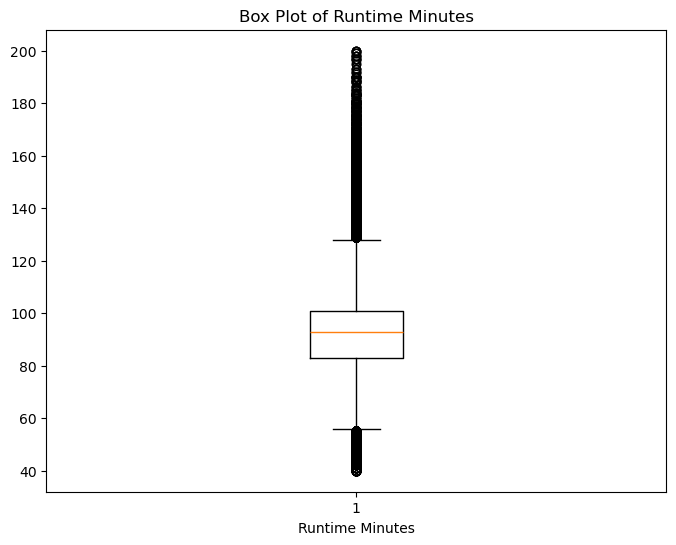

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot(imdf['runtime_minutes'], vert=True)
plt.xlabel('Runtime Minutes')
plt.title('Box Plot of Runtime Minutes')
plt.show()

In [19]:
imdf['genres'].value_counts().head()

genres
Drama           11546
Documentary      9179
Comedy           5155
Comedy,Drama     2502
Horror           2465
Name: count, dtype: int64

Creating binary columns (genre indicators) based on the unique genres in the `genres` column.

1. **Extract Unique Genres:**
   - Split the column into individual genres using `.str.split(',')` and then explode the resulting list to get unique genre values.

2. **Create Binary Columns:**
   - For each unique genre, check if that genre is present in the original column using `.str.contains(genre)`.
   - The result is converted to 1 (if the movie belongs to that genre) or 0 (otherwise).

In [20]:
unique_genres = imdf['genres'].str.split(',').explode().unique()

for genre in unique_genres:
    imdf[f'is_{genre}'] = imdf['genres'].str.contains(genre).astype(int)

- Convert the `averagerating` column to integer data type (removing any decimal places). To ensure that the ratings are represented as whole numbers (integers).

- The `.describe()` method provides summary statistics for the modified column. It includes count, mean, standard deviation, minimum, quartiles, and maximum.

In [21]:
imdf['averagerating'] = imdf['averagerating'].astype('int')
imdf['is_original_title'] = imdf['is_original_title'].astype('int')
imdf['numvotes'] = imdf['numvotes'].astype('int')
imdf[['averagerating', 'is_original_title', 'ordering', 'numvotes']].describe()

,averagerating,is_original_title,ordering,numvotes
count,69171.000000,69171.000000,69171.0,6.917100e+04
mean,5.863946,0.145234,1.0,3.755296e+03
std,1.484655,0.352339,0.0,3.128829e+04
min,1.000000,0.000000,1.0,5.000000e+00
25%,5.000000,0.000000,1.0,1.500000e+01
50%,6.000000,0.000000,1.0,5.400000e+01
75%,7.000000,0.000000,1.0,3.130000e+02
max,10.000000,1.000000,1.0,1.841066e+06


Permanently drop the columns `primary_title`, `original_title`, and `title` from the DataFrame.

In [22]:
imdf.drop(['movie_id', 'title', 'numvotes', 'genres', 'original_title', 'primary_title'], axis=1, inplace=True)

In [23]:
# First, select 1000 random entries
random_sample = imdf.sample(n=100, random_state=42)

# Next, save the random sample to a CSV file
random_sample.to_csv('im.csv', index=False)

print("Random sample saved to 'im.csv'")

Random sample saved to 'im.csv'


In [24]:
# Next, save the random sample to a CSV file
imdf.to_csv('./Data/imdf.csv', index=False)

print("Random sample saved to 'imdf'")

Random sample saved to 'imdf'


## `tn.movie_budgets.csv` DataFrame Cleaning

In [25]:
# Loading the dataframe
TN_df= pd.read_csv("./Data/tn.movie_budgets.csv", index_col= 0)

#### Initial Data Inspection

Getting a preview of the first 10 rows

In [26]:
TN_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


Getting basic information about the whole dataset

In [27]:
TN_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


In [28]:
TN_df.describe()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
count,5782,5782,5782,5782,5782
unique,2418,5698,509,5164,5356
top,"Dec 31, 2014",Home,"$20,000,000",$0,$0
freq,24,3,231,548,367


In [29]:
TN_df.shape

(5782, 5)

#### Data wrangling

**Handling missing values**

In [30]:
# Checking for missing values
TN_df.isnull().sum()

release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

There are no missing values in this dataframe

**Cleaning of the release date column**

In [31]:
# Getting a preview of the first 5 rows of the "release_date" column
TN_df["release_date"].head()

id
1    Dec 18, 2009
2    May 20, 2011
3     Jun 7, 2019
4     May 1, 2015
5    Dec 15, 2017
Name: release_date, dtype: object

For my analysis it would be more helpful to split this data into release month and release year.

In [32]:
# Converting the release_date column to datetime format
TN_df["release_date"] = pd.to_datetime(TN_df["release_date"])

# Creating new columns for "release_year" and "release_month" by splitting the "release_date" column
TN_df["release_year"]= TN_df["release_date"].dt.year
TN_df["release_month"]= TN_df["release_date"].dt.month

# Preview of the first 3 rows of the resulting  dataframe
TN_df.head(3)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
id,,,,,,,
1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,12
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,5
3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,6


Now that we have split the release date in year and months we no longer have use for the release date column, hence we will drop it from the dataframe.

In [33]:
# Dropping the "release_date" column
TN_df = TN_df.drop(columns ="release_date", axis=1)
TN_df.head(3)

,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
id,,,,,,
1,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,12
2,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,5
3,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,6


**Cleaning the movie column**

Checking to see if there are duplicates. All the values in the "movie" column should be unique.

In [34]:
# Getting info about the movie column
TN_df["movie"].describe()

count     5782
unique    5698
top       Home
freq         3
Name: movie, dtype: object

The number of unique values not being equal to the total count of values shows that there are some duplicates in the movie column. The difference between the total counts and the unique values shows that there are 84 duplicated values. Below we check for duplicates and drop rows where the movie column has duplicate values.

In [35]:
# Creating a dataframe that combines rows where the movie column has duplicate values in the TN_df dataframe.

duplicate_movies = TN_df[TN_df.duplicated(subset='movie')]

# Getting a preview of the duplicated rows

duplicate_movies.head()

,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
id,,,,,,
74,Godzilla,"$125,000,000","$136,314,294","$376,000,000",1998,5
9,Robin Hood,"$99,000,000","$30,824,628","$84,747,441",2018,11
85,Fantastic Four,"$87,500,000","$154,696,080","$333,132,750",2005,7
44,The Mummy,"$80,000,000","$155,385,488","$416,385,488",1999,5
8,Hercules,"$70,000,000","$99,112,101","$250,700,000",1997,6


In [36]:
# Dropping rows where the movie column has duplicated values.

TN_df = TN_df.drop_duplicates(subset = ['movie'])

# Check if the changes have been implemented the new number of rows should now be 5698

TN_df.shape

(5698, 6)

**Cleaning the production_budget, domestic_gross and world_wide gross columns**

These columns represent financial figures thus it is important that we work with them in integer or float format to allow us to carry out mathematical functions on them.

In [37]:
# Checking their datatypes
TN_df.dtypes

movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
release_year          int32
release_month         int32
dtype: object

Since the three columns have object data types, we will convert them into integer format.

In [38]:
# Removing the commas and dollar signs from the columns

TN_df['production_budget'] = TN_df['production_budget'].replace('[\$,]','', regex=True)
TN_df['worldwide_gross'] = TN_df['worldwide_gross'].replace('[\$,]','', regex=True)
TN_df['domestic_gross'] = TN_df['domestic_gross'].replace('[\$,]','', regex=True)

# Converting the columns into integers
TN_df['production_budget'] = TN_df['production_budget'].astype("int64")
TN_df['worldwide_gross'] = TN_df['worldwide_gross'].astype("int64")
TN_df['domestic_gross'] = TN_df['domestic_gross'].astype("int64")

# Previewing the results, looking at the first 3 rows
TN_df.head(3)

,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
id,,,,,,
1,Avatar,425000000,760507625,2776345279,2009,12
2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5
3,Dark Phoenix,350000000,42762350,149762350,2019,6


The data showing that there were movies that did not generate any revenue at all could be a sign that data was entered incorrectly. Hence we shall drop all rows where the world_wide gross is 0.

In [39]:
# Retaining rows where the values in the world_wide gross is greater than zero
TN_df = TN_df[TN_df['worldwide_gross'] > 0]

# checking that the zero values have been dropped.
assert (TN_df['worldwide_gross'] == 0).sum() == 0

Creating a profit column to allow us to access the profitability of each movie.

In [40]:
# Creating a profit column by subtracting the  production_budget from the worldwide_gross
TN_df["profit"] = (TN_df['worldwide_gross'] - TN_df['production_budget'])

# preview of the resultant dataframe
TN_df.head()

,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit
id,,,,,,,
1,Avatar,425000000,760507625,2776345279,2009,12,2351345279
2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5,635063875
3,Dark Phoenix,350000000,42762350,149762350,2019,6,-200237650
4,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,5,1072413963
5,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,12,999721747


In [41]:
# Next, save the random sample to a CSV file
TN_df.to_csv('./Data/TN_df.csv', index=False)

print("Random sample saved to 'TN_df'")

Random sample saved to 'TN_df'


### `bom.movie_gross` Data Cleaning

In [42]:
bomdf.shape

(3387, 5)

In [43]:
bomdf.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [44]:
bomdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [45]:
bomdf.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [46]:
missing_values = bomdf.isnull().sum() / len(bomdf) * 100
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 title              0.000000
studio             0.147623
domestic_gross     0.826690
foreign_gross     39.858282
year               0.000000
dtype: float64


In [47]:
# Count the number of NaN values
nan_count = bomdf['foreign_gross'].isna().sum()
print(f"Number of NaN values in 'foreign_gross': {nan_count}")

# Replace NaN values with 0
bomdf['foreign_gross'] = bomdf['foreign_gross'].fillna(0)

# Convert the column to numeric type before interpolating
bomdf['foreign_gross'] = pd.to_numeric(bomdf['foreign_gross'], errors='coerce')
bomdf['foreign_gross'] = bomdf['foreign_gross'].interpolate(method='linear')
bomdf['foreign_gross'] = bomdf['foreign_gross'].astype('int')

Number of NaN values in 'foreign_gross': 1350


In [48]:
def drop_columns_with_missing_values(df, threshold=0.1):
    # Calculate the percentage of missing values for each column
    missing_percent = df.isnull().mean()
    
    # Identify columns with missing values above the threshold
    columns_to_drop = missing_percent[missing_percent >= threshold].index
    
    # Drop the columns
    cleaned_df = df.drop(columns=columns_to_drop)
    
    return cleaned_df

bomdf = drop_columns_with_missing_values(bomdf, threshold=0.1)

In [49]:
missing_values = bomdf.isnull().sum() / len(bomdf) * 100
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 title             0.000000
studio            0.147623
domestic_gross    0.826690
foreign_gross     0.000000
year              0.000000
dtype: float64


In [50]:
def impute_missing_values(df):
    # Separate columns by data type
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Impute numeric columns with mean
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].mean())
    
    # Impute categorical columns with mode
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    return df
bomdf = impute_missing_values(bomdf)

In [51]:
missing_values = bomdf.isnull().sum() / len(bomdf) * 100
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 title             0.0
studio            0.0
domestic_gross    0.0
foreign_gross     0.0
year              0.0
dtype: float64


In [52]:
bomdf['domestic_gross'] = bomdf['domestic_gross'].astype('int')

In [53]:
bomdf['domestic_gross'].describe()

count    3.387000e+03
mean     2.874585e+07
std      6.670497e+07
min      1.000000e+02
25%      1.225000e+05
50%      1.400000e+06
75%      2.874584e+07
max      9.367000e+08
Name: domestic_gross, dtype: float64

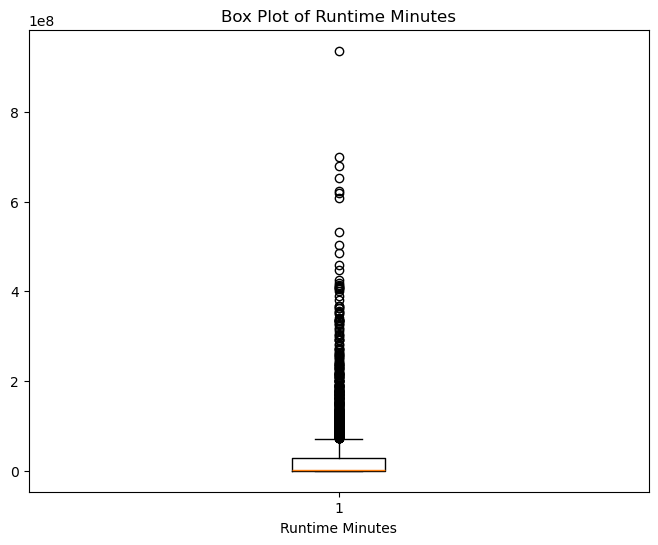

In [54]:
plt.figure(figsize=(8, 6))
plt.boxplot(bomdf['domestic_gross'], vert=True)
plt.xlabel('Runtime Minutes')
plt.title('Box Plot of Runtime Minutes')
plt.show()

In [55]:
bomdf.sort_values(by='domestic_gross', ascending=True).head()

,title,studio,domestic_gross,foreign_gross,year
1476,Storage 24,Magn.,100,0,2013
2757,Satanic,Magn.,300,0,2016
2756,News From Planet Mars,KL,300,0,2016
2321,The Chambermaid,FM,300,0,2015
1018,Apartment 143,Magn.,400,426000,2012


In [56]:
bomdf.sort_values(by='domestic_gross', ascending=True).tail()

,title,studio,domestic_gross,foreign_gross,year
727,Marvel's The Avengers,BV,623400000,895500000,2012
1873,Jurassic World,Uni.,652300000,473200000,2015
3079,Avengers: Infinity War,BV,678800000,323450000,2018
3080,Black Panther,BV,700100000,646900000,2018
1872,Star Wars: The Force Awakens,BV,936700000,236600000,2015


In [57]:
# Create a dictionary to map abbreviations to full names
studio_mapping = {
    'ifc': 'IFC Films',
    'uni.': 'Universal Pictures',
    'wb': 'Warner Bros',
    'magn.': 'Magnolia Pictures',
    'fox': '20th Century Fox',
    'spc': 'Sony Pictures Classics',
    'sony': 'Sony Pictures',
    'bv': 'Buena Vista (Disney)',
    'lgf': 'Lionsgate Films',
    'par.': 'Paramount Pictures',
    'eros': 'Eros International',
    'wein.': 'The Weinstein Company',
    'cl': 'Columbia Pictures',
    'strand': 'Strand Releasing',
    'foxs': 'Fox Searchlight Pictures',
    'ratt.': 'Rattapallax Films',
    'focus': 'Focus Features',
    'wgusa': 'Well Go USA Entertainment',
    'cj': 'CJ Entertainment',
    'mbox': 'Music Box Films',
    'utv': 'UTV Motion Pictures',
    'a24': 'A24',
    'wb (nl)': 'Warner Bros (Netherlands)',
    'lg/s': 'Lionsgate Entertainment',
    'cohen': 'Cohen Media Group',
    'orf': 'Open Road Films',
    'rela.': 'Relativity Media',
    'sgem': 'Samuel Goldwyn Films',
    'fip': 'FilmDistrict',
    'gold.': 'Gold Circle Films',
    'gk': 'GKIDS',
    'stx': 'STX Entertainment',
    'tris': 'TriStar Pictures',
    'osci.': 'Oscilloscope Laboratories',
    'rtwc': 'Roadside Attractions',
    'mne': 'Mongrel Media',
    'bst': 'Bleecker Street',
    'eone': 'Entertainment One',
    'drft.': 'Draft House Films',
    'distrib.': 'Not Specified',
    'relbig.': 'Reliance Big Pictures',
    'anch.': 'Anchor Bay Films',
    'cbs': 'CBS Films',
    'zeit.': 'Zeitgeist Films',
    'bg': 'Bodega Films',
    'sum.': 'Summit Entertainment',
    'w/dim.': 'Walt Disney Studios Motion Pictures',
    'fd': 'FilmDistrict',
    'trib.': 'Not Specified',
    'yash': 'Yash Raj Films',
    'orch.': 'Orchard',
    'frun': 'Not Specified',
    'fun': 'Not Specified',
    'fcw': 'Not Specified',
    'free': 'Not Specified',
    'lorb.': 'Not Specified',
    'pnt': 'Not Specified',
    'elev.': 'Not Specified',
    'Orchard': 'The Orchard',
    'scre.': 'Screen Gems',
    'cgld': 'Cinedigm',
    'vari.': 'Variety',
    'abr.': 'Abramorama',
    'p/dw': 'Paramount/DreamWorks',
    'fathom': 'Fathom Events',
    'fr': 'FilmRise',
    've': 'Vertical Entertainment',
    'kino': 'Kino Lorber',
    'good deed': 'Good Deed Entertainment',
    'grtindia': 'GRT India',
    'hc': 'Not Specified',
    'jampa': 'Jampa Films',
    'linn': 'Linn Productions',
    'trafalgar': 'Trafalgar Releasing',
    'scre.': 'Screen Gems',
    'cgld': 'Cinedigm',
    'vari.': 'Variety',
    'abr.': 'Abramorama',
    'p/dw': 'Paramount',
    'fathom': 'Fathom Events',
    'fr': 'FilmRise',
    've': 'Vertical Entertainment',
    'kino': 'Kino Lorber',
    'dreamwest': 'Dreamwest Films',
    'cleopatra': 'Cleopatra Entertainment',
    'app.': 'Not Specified',
    'saban': 'Saban Films',
    'mpft': 'Not Specified',
    'am': 'Not Specified',
    'kc': 'Not Specified',
    'libre': 'Libre Entertainment',
}

# Convert the 'studio' column to lowercase
bomdf['studio'] = bomdf['studio'].str.lower()

# Replace the studio names in the 'studio' column
bomdf['studio'] = bomdf['studio'].replace(studio_mapping)

# Check the value counts again
print(bomdf['studio'].value_counts().head())

studio
IFC Films             171
Universal Pictures    147
Warner Bros           140
20th Century Fox      136
Magnolia Pictures     136
Name: count, dtype: int64


In [58]:
bomdf.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,Buena Vista (Disney),415000000,652000000,2010
1,Alice in Wonderland (2010),Buena Vista (Disney),334200000,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,Warner Bros,296000000,664300000,2010
3,Inception,Warner Bros,292600000,535700000,2010
4,Shrek Forever After,Paramount,238700000,513900000,2010


In [59]:
# Next, save the random sample to a CSV file
bomdf.to_csv('./Data/bomdf.csv', index=False)

print("Random sample saved to 'bomdf'")

Random sample saved to 'bomdf'


## `rt.movie_info.tsv` Data Cleaning

In [60]:
# Loading the database
rtmdf = pd.read_csv('./Data/rt.movie_info.tsv', sep= '\t', index_col=0)

In [61]:
# Cchecking the dataset's first and last five rows
rtmdf.head()

,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
id,,,,,,,,,,,
1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [62]:
rtmdf.info() #Checking the data types of columns

<class 'pandas.core.frame.DataFrame'>
Index: 1560 entries, 1 to 2000
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   synopsis      1498 non-null   object
 1   rating        1557 non-null   object
 2   genre         1552 non-null   object
 3   director      1361 non-null   object
 4   writer        1111 non-null   object
 5   theater_date  1201 non-null   object
 6   dvd_date      1201 non-null   object
 7   currency      340 non-null    object
 8   box_office    340 non-null    object
 9   runtime       1530 non-null   object
 10  studio        494 non-null    object
dtypes: object(11)
memory usage: 146.2+ KB


In [63]:
# Assuming rtmdf is your DataFrame
rtmdf[['director', 'writer']] = rtmdf[['director', 'writer']].fillna('Other')

# Verify the changes
print(rtmdf[['director', 'writer']].isnull().sum())

director    0
writer      0
dtype: int64


In [64]:
rtmdf.isnull().sum() / len(rtmdf) *  100

synopsis         3.974359
rating           0.192308
genre            0.512821
director         0.000000
writer           0.000000
theater_date    23.012821
dvd_date        23.012821
currency        78.205128
box_office      78.205128
runtime          1.923077
studio          68.333333
dtype: float64

In [65]:
def drop_columns_with_missing_values(df, threshold=0.10):
    # Calculate the percentage of missing values for each column
    missing_percent = df.isnull().mean()
    
    # Identify columns with missing values above the threshold
    columns_to_drop = missing_percent[missing_percent >= threshold].index
    
    # Drop the columns
    cleaned_df = df.drop(columns=columns_to_drop)
    
    return cleaned_df

rtmdf = drop_columns_with_missing_values(rtmdf, threshold=0.10)

In [66]:
import pandas as pd

def impute_missing_values(df):
    # Separate columns by data type
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Impute numeric columns with mean
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].mean())
    
    # Impute categorical columns with mode
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    return df
rtmdf = impute_missing_values(rtmdf)

In [67]:
rtmdf.isnull().sum() / len(rtmdf) *  100

synopsis    0.0
rating      0.0
genre       0.0
director    0.0
writer      0.0
runtime     0.0
dtype: float64

In [68]:
rtmdf = rtmdf.drop(columns='synopsis')

In [69]:
# Replace 'NR' with 'Not Rated' and 'NC17' with 'NC-17'
rtmdf['rating'] = rtmdf['rating'].replace({'NR': 'Not Rated', 'NC17': 'NC-17'})

In [70]:
rtmdf['rating'].value_counts()

rating
R            524
Not Rated    503
PG           240
PG-13        235
G             57
NC-17          1
Name: count, dtype: int64

In [71]:
# First we replace and with pipe symbol then split the genres using pipe symbol delimeter.
unique_genres = rtmdf['genre'].str.replace(' and ', '|').str.split('|').explode().unique()

# Iterate over the unique genres and create new binary columns.
for genre in unique_genres:
    rtmdf[f'is_{genre}'] = rtmdf['genre'].str.contains(genre).astype(int)

In [72]:
rtmdf.columns

Index(['rating', 'genre', 'director', 'writer', 'runtime', 'is_Action',
       'is_Adventure', 'is_Classics', 'is_Drama', 'is_Science Fiction',
       'is_Fantasy', 'is_Musical', 'is_Performing Arts', 'is_Mystery',
       'is_Suspense', 'is_Romance', 'is_Kids', 'is_Family', 'is_Comedy',
       'is_Documentary', 'is_Special Interest', 'is_Art House',
       'is_International', 'is_Horror', 'is_Western', 'is_Television',
       'is_Sports', 'is_Fitness', 'is_Animation', 'is_Faith',
       'is_Spirituality', 'is_Cult Movies', 'is_Anime', 'is_Manga', 'is_Gay',
       'is_Lesbian'],
      dtype='object')

In [73]:
rtmdf['runtime'].head()

id
1    104 minutes
3    108 minutes
5    116 minutes
6    128 minutes
7    200 minutes
Name: runtime, dtype: object

In [74]:
# Remove the word 'minutes' and convert to integer
rtmdf['runtime'] = rtmdf['runtime'].str.replace(' minutes', '').astype(int)
rtmdf['runtime'].head()

id
1    104
3    108
5    116
6    128
7    200
Name: runtime, dtype: int64

In [75]:
# Filtering to a range of 40 to 200 minute
rtmdf = rtmdf[(rtmdf['runtime'] >= 40) & (rtmdf['runtime'] <= 200)]

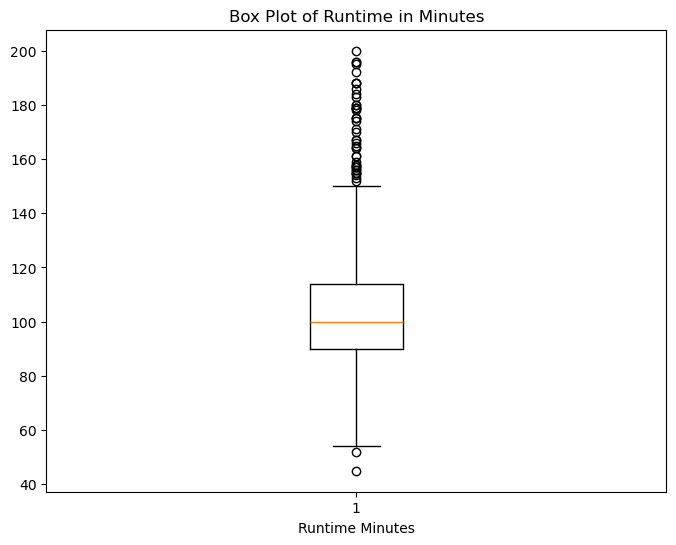

In [76]:
plt.figure(figsize=(8, 6))
plt.boxplot(rtmdf['runtime'])
plt.xlabel('Runtime Minutes')
plt.title('Box Plot of Runtime in Minutes')
plt.show()

In [77]:
# Next, save the random sample to a CSV file
rtmdf.to_csv('./Data/rtmdf.csv', index=False)

print("Random sample saved to 'rtmdf'")

Random sample saved to 'rtmdf'


## Merge the DataFrames

In [78]:
# Rename columns for consistency
imdf.rename(columns={'start_year': 'year'}, inplace=True)
TN_df.rename(columns={'release_year': 'year'}, inplace=True)

In [79]:
imdf.columns

Index(['year', 'runtime_minutes', 'averagerating', 'ordering',
       'is_original_title', 'is_Action', 'is_Crime', 'is_Drama',
       'is_Biography', 'is_Comedy', 'is_Fantasy', 'is_Horror', 'is_Thriller',
       'is_Adventure', 'is_Animation', 'is_History', 'is_Documentary',
       'is_Mystery', 'is_Sci-Fi', 'is_Family', 'is_Romance', 'is_War',
       'is_Music', 'is_Sport', 'is_Western', 'is_Musical', 'is_News',
       'is_Reality-TV', 'is_Game-Show', 'is_Adult'],
      dtype='object')

In [80]:
TN_df.columns

Index(['movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'release_month', 'profit'],
      dtype='object')

In [81]:
bomdf.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [82]:
# Create a SQLite database
conn1 = sqlite3.connect('movies.db')

# Write DataFrames to SQL tables
imdf.to_sql('imdf', conn, if_exists='replace', index=False)
TN_df.to_sql('TN_df', conn, if_exists='replace', index=False)
bomdf.to_sql('bomdf', conn, if_exists='replace', index=False)

3387

In [83]:
# Performing SQL merge
query = """
    SELECT *
    FROM imdf
    JOIN TN_df ON imdf.year = TN_df.year
    JOIN bomdf ON imdf.year = bomdf.year
    LIMIT 5
"""
df = pd.read_sql_query(query, conn1)
df.head()

,movie_id,primary_title,original_title,year,runtime_minutes,averagerating,ordering,is_original_title,is_Action,is_Crime,...,production_budget,domestic_gross,worldwide_gross,year,release_month,profit,title,studio,domestic_gross,year
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,7,1,0,1,1,...,20000000,56671993,181025343,2013,10,161025343,12 Years a Slave,Fox Searchlight Pictures,56700000,2013
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,7,1,0,1,1,...,20000000,56671993,181025343,2013,10,161025343,2 Guns,Universal Pictures,75600000,2013
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,7,1,0,1,1,...,20000000,56671993,181025343,2013,10,161025343,20 Feet from Stardom,Roadside Attractions,4900000,2013
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,7,1,0,1,1,...,20000000,56671993,181025343,2013,10,161025343,21 and Over,Relativity Media,25700000,2013
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,7,1,0,1,1,...,20000000,56671993,181025343,2013,10,161025343,22 Bullets,cdgm.,28745845,2013


In [84]:
# Next, save the random sample to a CSV file
df.to_csv('./Data/mergeddf.csv', index=False)

print("Random sample saved to 'mergedf'")

Random sample saved to 'mergedf'


## Exploratory Data Analysis

In this section, we perform Exploratory Data Analysis (EDA) to summarize and visualize the main characteristics of our datasets. This process will helps us uncover patterns, spot anomalies, test hypotheses, and check assumptions using various statistical graphics and data visualization methods. By employing summary statistics and visual tools like histograms, scatter plots, box plots, and heat maps, we aim to understand the underlying structure of the data and identify relationships between variables, which will help us provide the investor with insights.


### Univariate Analysis

In the Univariate Analysis section, we focus on examining the statistical properties of individual variables in our dataset. By analyzing one variable at a time, we can identify patterns, detect outliers, and gain a clear understanding of each variable's behavior, which is essential for accurate data interpretation and further analysis.

### **Graph of Number of Movies by Year from 2015 to 2021.**

- The horizontal axis represents the years, while the vertical axis represents the number of movies, with increments of 100 up to 500. 

- The bars indicate a general decline in the number of movies released over these years, with the highest number around 2015 and a gradual decrease towards 2021. 

- This trend reflect changes in the film industry or external factors affecting movie production and releases during this period.

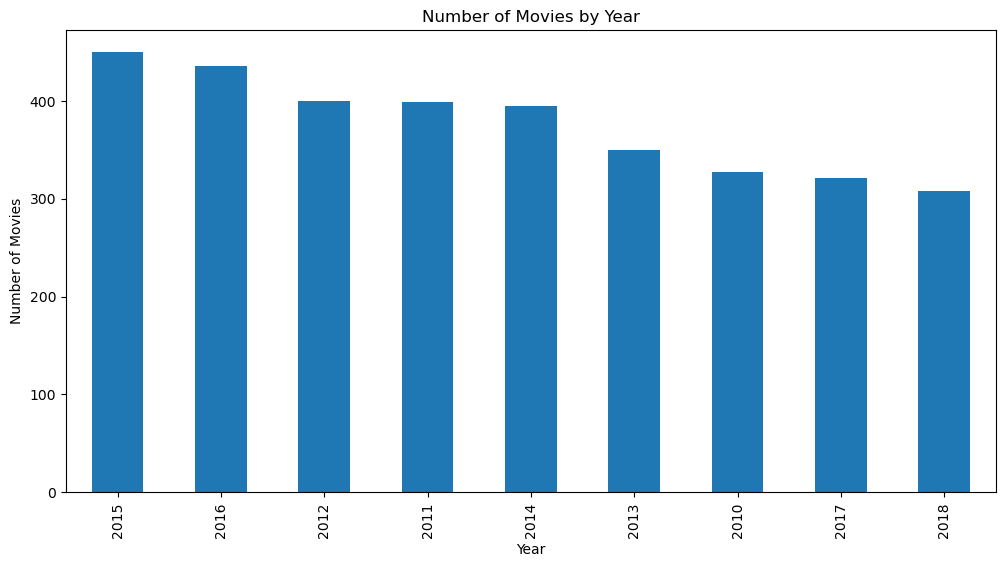

In [85]:
#Number of movies by year
bomdf['year'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Year')
plt.show()

### **The Graph of Number of Movies by Studio**

- The horizontal axis lists different studios, while the vertical axis represents the number of movies, ranging from 0 to 160.
- **IFC Films** has the highest number of movies produced.
- **Universal Pictures** and **Warner Bros.** follow, with significant numbers of movies.
- **Well Go USA Entertainment** has the least number of movies among the listed studios.

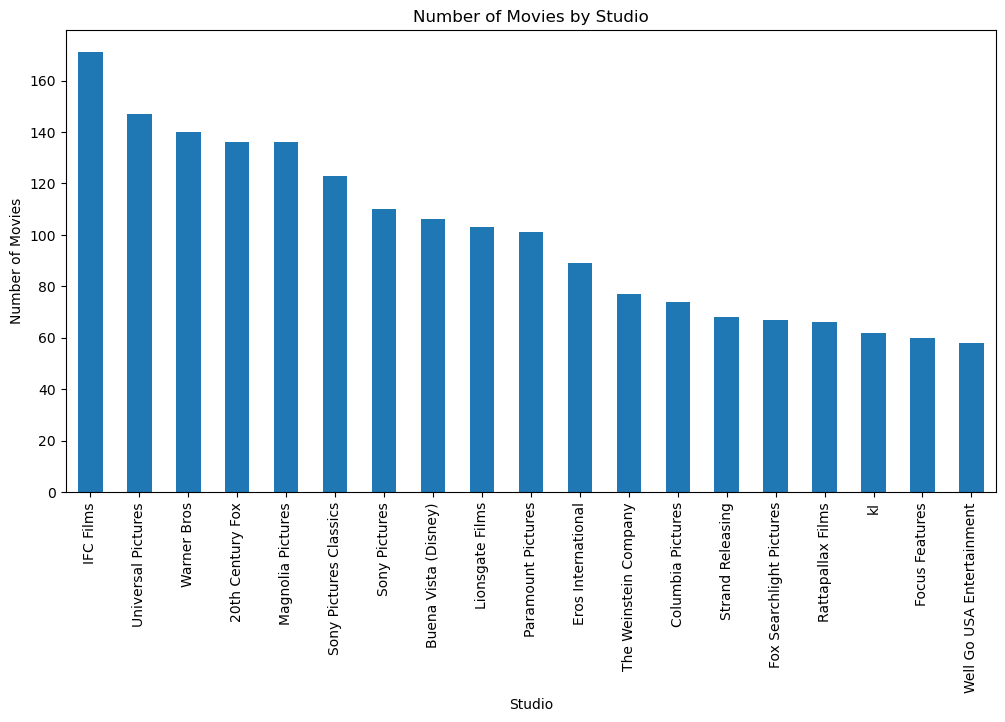

In [86]:
# Get the top 20 studios
top_20_studios = bomdf['studio'].value_counts().nlargest(20)

# Exclude 'Not Specified' category
top_20_studios = top_20_studios[top_20_studios.index != 'Not Specified']

# Plot the data
top_20_studios.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Studio')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Studio')
plt.show()

### **Distribution of Average Rating**

- The distribution of average ratings shows how movies are rated by viewers. This can help identify the overall quality perception of movies in the dataset.
- Average ratings are a crucial metric for understanding audience satisfaction and movie success.
1. **Quality Benchmark**: Knowing the distribution of ratings helps establish a benchmark for the quality of movies the company should aim for. E.g an average 6 rating is the mode hence the threshold performance
2. **Genre Preferences**: Certain genres might consistently receive higher ratings, indicating stronger audience preferences.
3. **Improvement Areas**: Identifying genres or types of movies with lower average ratings can highlight areas for improvement or innovation.
4. **Quality Goals**: Aim for an average rating that aligns with successful movies to ensure high audience satisfaction.
5. **Genre Targeting**: Identify and focus on genres that consistently receive higher ratings and are more popular among audiences.


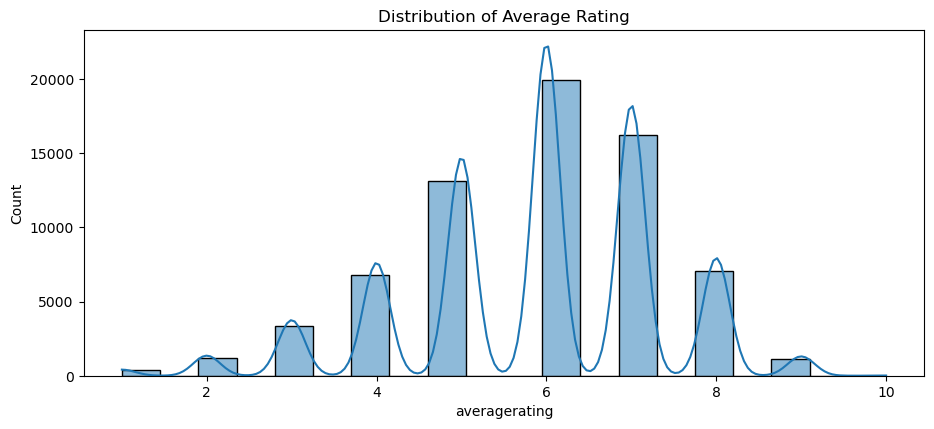

In [87]:
# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Set up the matplotlib figure
plt.figure(figsize=(18, 8))

# Distribution of averagerating
plt.subplot(2, 2, 3)
sns.histplot(imdf['averagerating'].dropna(), kde=True, bins=20)
plt.title('Distribution of Average Rating')

plt.tight_layout()
plt.show();

# Re-enable warnings if needed
warnings.filterwarnings('default', category=FutureWarning)

### **Histogram of Top 10 Directors by Frequency of Movies Directed**

- The x-axis lists the directors, and the y-axis represents the frequency of movies, ranging from 0 to 10.
- **Steven Spielberg** has directed the most movies, with a frequency close to 8.
- Most other directors, such as **Woody Allen**, **Clint Eastwood**, and **Alfred Hitchcock**, have directed between 4 and 6 movies.
- The chart highlights the prominence of directors in terms of the number of movies they have directed. 

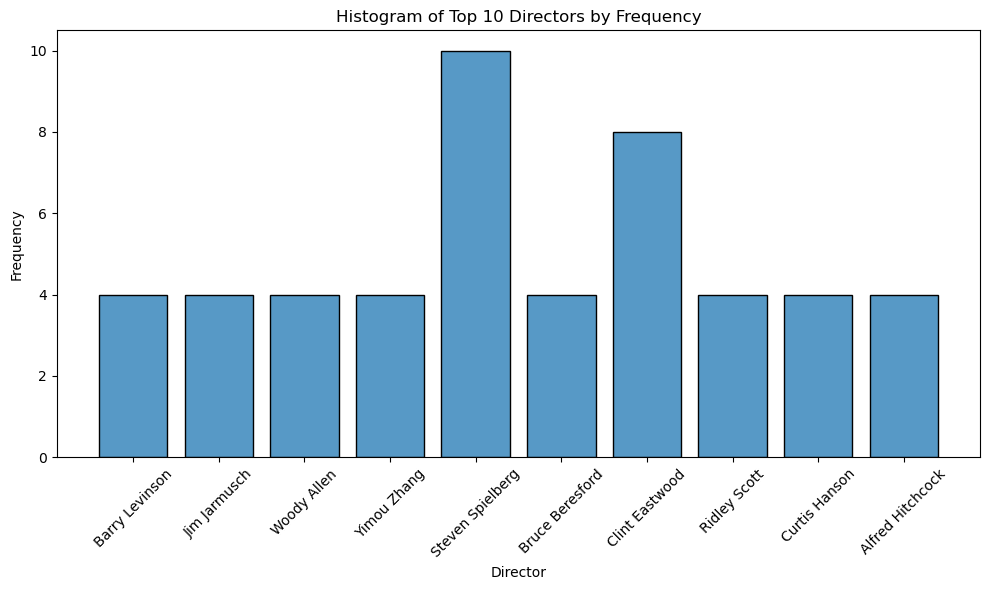

In [88]:
# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Get the top 10 directors, excluding 'Other'
top_10_directors = rtmdf['director'].value_counts().head(11).index
top_10_directors = top_10_directors[top_10_directors != 'Other']

# Filter the DataFrame to include only the top 10 directors
top_10_df = rtmdf[rtmdf['director'].isin(top_10_directors)]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=top_10_df, x='director', shrink=.8)
plt.xticks(rotation=45)
plt.xlabel('Director')
plt.ylabel('Frequency')
plt.title('Histogram of Top 10 Directors by Frequency')
plt.tight_layout()
plt.show();

# Re-enable warnings if needed
warnings.filterwarnings('default', category=FutureWarning)

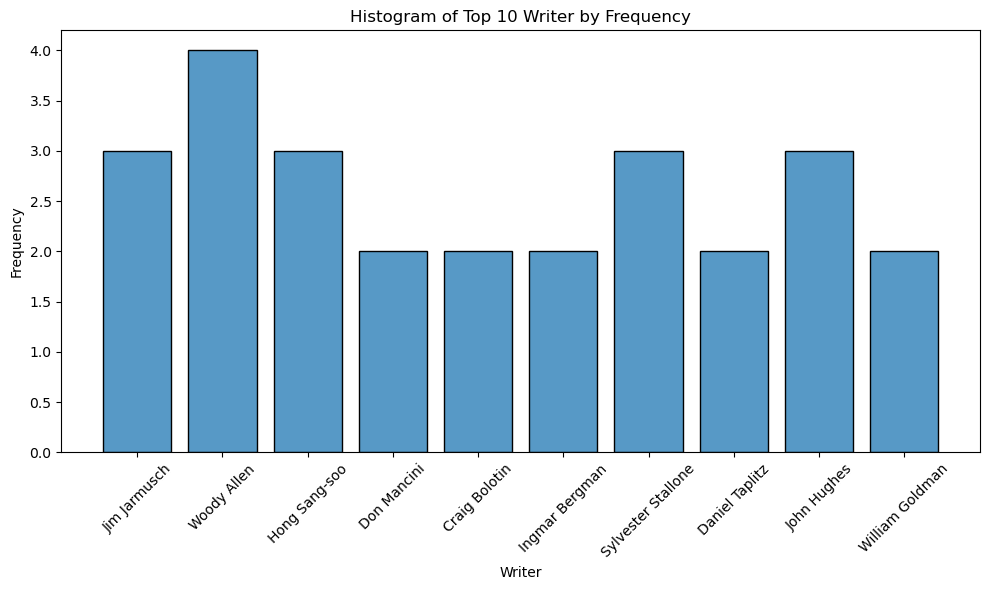

In [89]:
# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Get the top 10 directors, excluding 'Other'
top_10_writers = rtmdf['writer'].value_counts().head(11).index
top_10_writers = top_10_writers[top_10_writers != 'Other']

# Filter the DataFrame to include only the top 10 directors
top_10_df = rtmdf[rtmdf['writer'].isin(top_10_writers)]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=top_10_df, x='writer', shrink=.8)
plt.xticks(rotation=45)
plt.xlabel('Writer')
plt.ylabel('Frequency')
plt.title('Histogram of Top 10 Writer by Frequency')
plt.tight_layout()
plt.show();

# Re-enable warnings if needed
warnings.filterwarnings('default', category=FutureWarning)

### **The Distribution of Production Budget based on Movie Frequency**

- The horizontal axis represents the production budget, ranging from 0 to 400 million, while the vertical axis represents the frequency, with values going above 2000.
- The majority of movies have lower production budgets, as indicated by the high frequency at the lower end of the budget spectrum.
- As the production budget increases, the frequency of movies decreases.

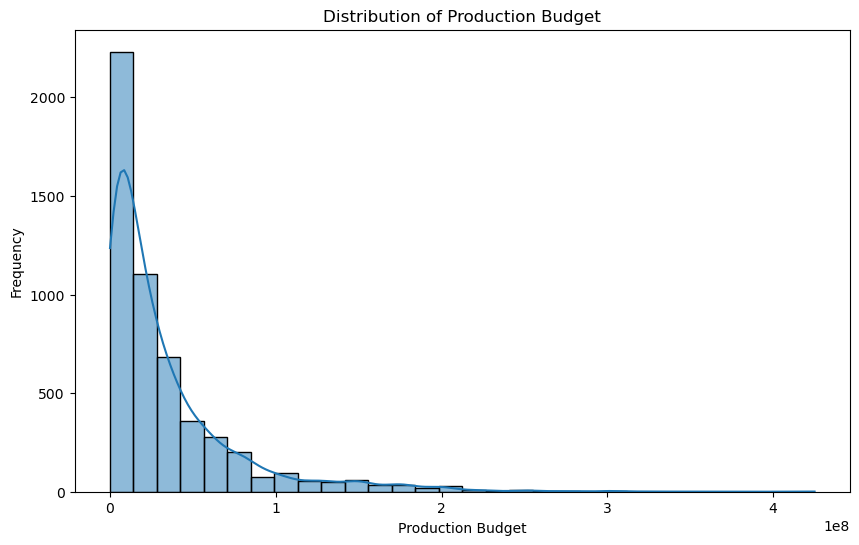

In [90]:
# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Plotting Histogram
plt.figure(figsize=(10, 6))
sns.histplot(TN_df['production_budget'], bins=30, kde=True)
plt.title('Distribution of Production Budget')
plt.xlabel('Production Budget')
plt.ylabel('Frequency')
plt.plot();

# Re-enable warnings if needed
warnings.filterwarnings('default', category=FutureWarning)

# Bivariate analysis

The Bivariate Analysis section investigates the relationships between pairs of variables exploring how the two variables interact with each other. This analysis helps us uncover associations, trends, and dependencies that might exist between variables.

### **Top 10 Studios by Domestic and Foreign Gross** 

- Comparing the gross earnings of the top 10 film studios in both domestic (blue bars) and foreign (orange bars) markets. 
- The vertical axis represents the gross earnings in billions, ranging from 0 to 10.
- **Buena Vista (Disney)** has the highest combined gross, with significant earnings in both domestic and foreign markets.
- **Universal Pictures** and **Warner Bros** also show substantial earnings, with a notable portion coming from foreign markets.
- The chart highlights the global reach and financial performance of these major studios, indicating their success in both domestic and international markets.

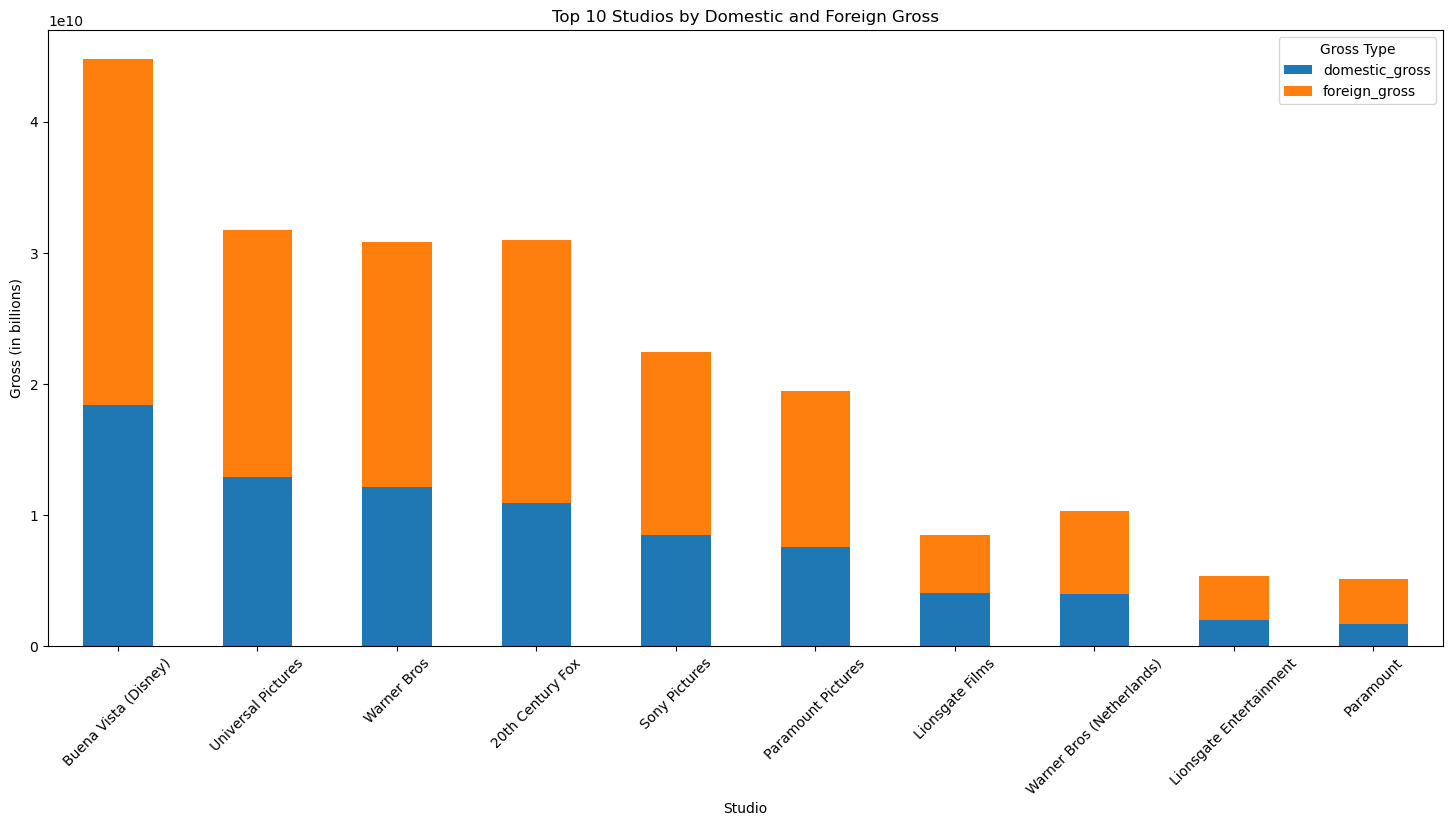

In [91]:
# Filter out zeros in domestic and foreign gross
filtered_data = bomdf[(bomdf['domestic_gross'] != 0) & (bomdf['foreign_gross'] != 0)]

# Group by studio and calculate the sum of domestic and foreign gross
studio_gross = filtered_data.groupby('studio')[['domestic_gross', 'foreign_gross']].sum()

# Sort by domestic and foreign gross and select the top 10 studios
top_studios = studio_gross.sort_values(by=['domestic_gross', 'foreign_gross'], ascending=False).head(10)

# Plotting
fig, ax = plt.subplots(figsize=(18, 8))
top_studios.plot(kind='bar', stacked=True, ax=ax)

# Labeling
plt.title('Top 10 Studios by Domestic and Foreign Gross')
plt.xlabel('Studio')
plt.ylabel('Gross (in billions)')
plt.xticks(rotation=45)
plt.legend(title='Gross Type')
plt.show();

### **Average Rating by Genre**

Analyzing the performance of each genre based on the average ratings:

1. **Drama**: This genre has the highest median rating, indicating that it tends to receive favorable ratings from viewers.

2. **Comedy** and **Documentary**: They have relatively high median rating, suggesting consistent positive reception.

3. **Fantasy**, **Adventure**, **Sci-Fi**, and **Action**: These genres have wider boxes, indicating mixed ratings.

4. **Crime**, **Romance**, **Mystery**, and **Family**: These genres have moderate median ratings.

5.  **Comedy**, **Fantasy**, **Adventure**, **Sci-Fi**, **Action**, **Music**, **Sport**, and **Western**: These genres show variability in ratings.

6. **Thriller**, **History**, **Reality-TV**, and **Game Show**: These genres have relatively low median ratings.

7. **Horror**: Horror has the lowest median rating, suggesting it's the least popular genre in terms of viewer ratings.

> The best-performing genre is Documentary, while Horror is the least favored.

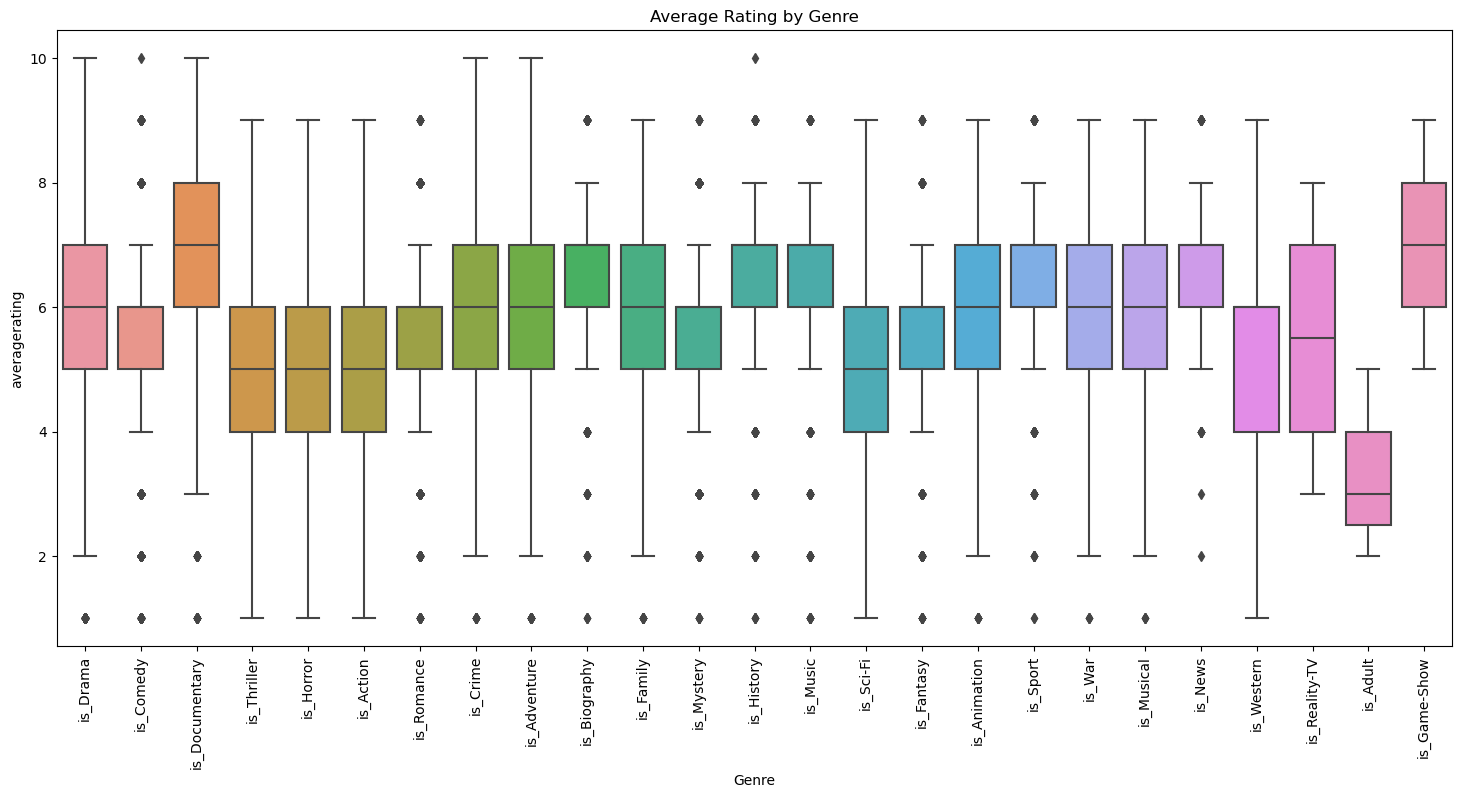

In [92]:
# Calculate the sum of each column
genre_sums = imdf[[
    'is_Action', 'is_Crime', 'is_Drama', 'is_Biography', 'is_Comedy',
    'is_Fantasy', 'is_Horror', 'is_Thriller', 'is_Adventure',
    'is_Animation', 'is_History', 'is_Documentary', 'is_Mystery',
    'is_Sci-Fi', 'is_Family', 'is_Romance', 'is_War', 'is_Music',
    'is_Sport', 'is_Western', 'is_Musical', 'is_News', 'is_Reality-TV',
    'is_Game-Show', 'is_Adult'
]].sum()

# Sort the sums in descending order
sorted_genre_sums = genre_sums.sort_values(ascending=False)

# Get the sorted genre columns
sorted_genre_columns = sorted_genre_sums.index.tolist()

# Melt the DataFrame to long format for seaborn
data_melted = imdf.melt(id_vars=['averagerating'], value_vars=sorted_genre_columns, var_name='Genre', value_name='Is_Genre')

# Filter out rows where Is_Genre is 0
data_melted = data_melted[data_melted['Is_Genre'] == 1]

# Plot the average ratings for each genre
plt.figure(figsize=(18, 8))
sns.boxplot(x='Genre', y='averagerating', data=data_melted, order=sorted_genre_columns)
plt.xticks(rotation=90)
plt.title('Average Rating by Genre')
plt.show();

### **Distribution of Movie Runtimes (in minutes) for Different Rating Categories (PG, R, Not Rated, PG-13, G, and NC-17)**

- The x-axis shows the runtime in minutes, while the y-axis shows the count of movies.
- **PG and PG-13**: These categories have a wide range of runtimes, with a noticeable peak around 100-120 minutes.
- **R**: Movies in this category also show a broad distribution, with many movies around the 90-120 minute mark.
- **Not Rated (NR)**: This category has a varied distribution, with a significant number of movies in the 80-100 minute range.
- **G**: Generally shorter runtimes, with most movies around 80-100 minutes.
- **NC-17**: Fewer movies overall, with runtimes mostly between 90-120 minutes.

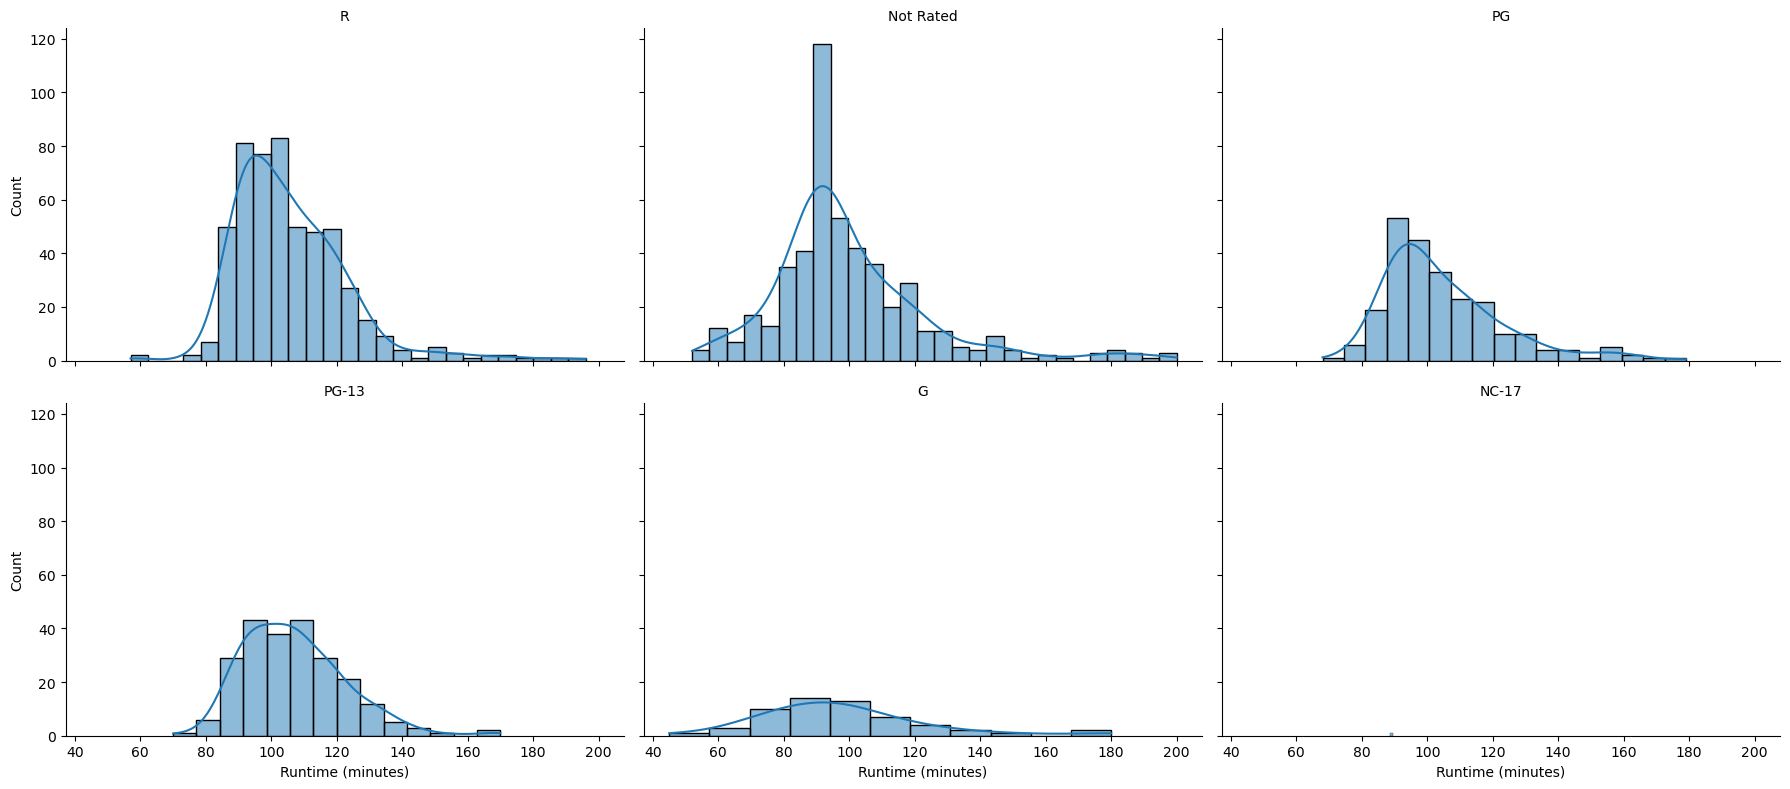

In [93]:
# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Replace infinite values with NaN
rtmdf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Create Facet Grid
g = sns.FacetGrid(rtmdf, col='rating', col_wrap=3, height=4, aspect=1.5)
g.map(sns.histplot, 'runtime', kde=True)
g.set_titles('{col_name}')
g.set_axis_labels('Runtime (minutes)', 'Count')
plt.show()

# Re-enable warnings if needed
warnings.filterwarnings('default', category=FutureWarning)

### **Relationship Between Production Budgets and Profits for Movies** 

- The x-axis represents the production budget, ranging from 0 to 400 million, while the y-axis represents the profit, ranging from 0 to 2 billion.
- Most data points are clustered towards the lower end of both axes, indicating that many movies have lower production budgets and profits.
- There are a few data points with higher production budgets and profits, suggesting that some movies with larger budgets also achieve higher profits.

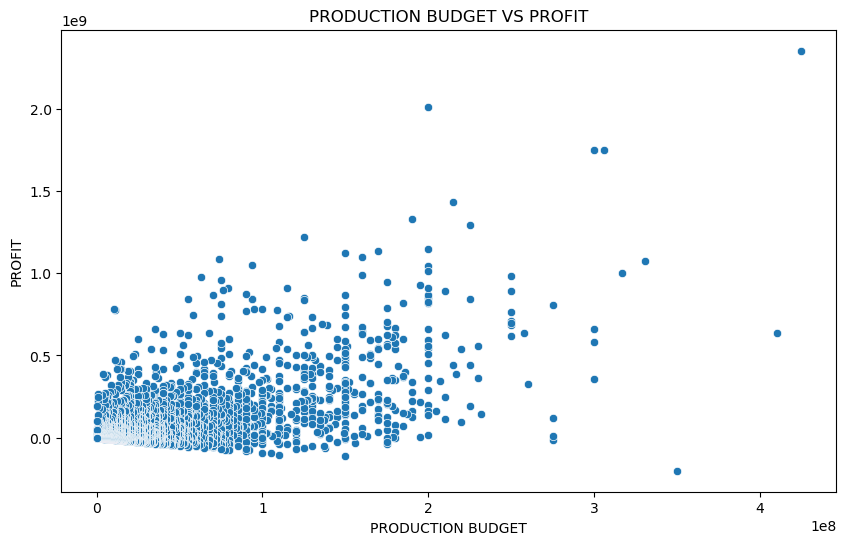

In [94]:
# Creating the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='production_budget', y='profit', data=TN_df)
plt.title('PRODUCTION BUDGET VS PROFIT')
plt.xlabel('PRODUCTION BUDGET')
plt.ylabel('PROFIT');

# Displaying the plot
plt.show()

### **The Average Profit of Movies Released in Each Month of the Year**

- The horizontal axis represents the release months from January (1) to December (12), while the vertical axis represents the average profit in billions.
- **May, June, and July**: These months have the highest average profits, indicating that movies released during the summer tend to perform better financially.
- **January, February, and September through December**: These months have lower average profits, suggesting that movies released during these periods tend to earn less on average.

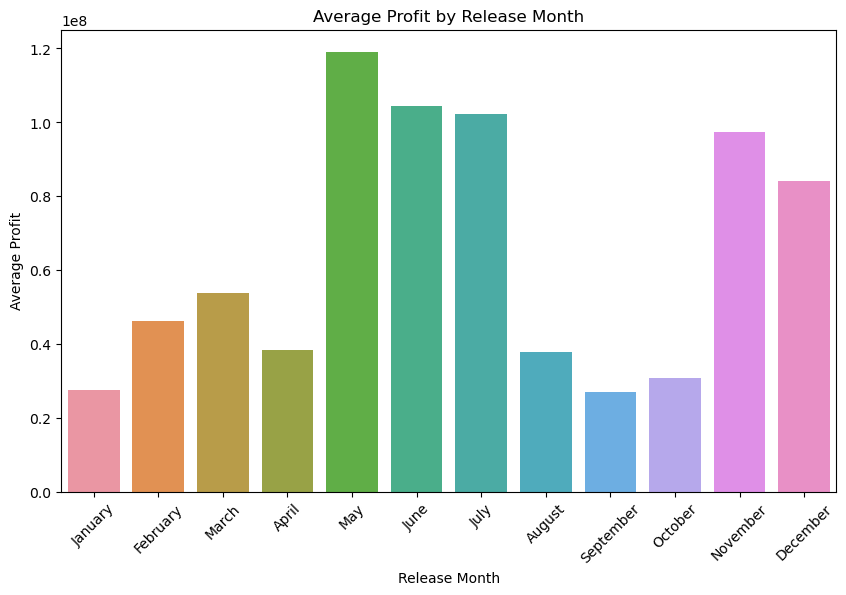

In [95]:
# Aggregating profit by release month
monthly_profit = TN_df.groupby('release_month')['profit'].mean().reset_index()

# Mapping numeric months to month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
monthly_profit['release_month'] = monthly_profit['release_month'].map(month_names)

# Plotting the aggregated data
plt.figure(figsize=(10, 6))
sns.barplot(x='release_month', y='profit', data=monthly_profit, order=list(month_names.values()))
plt.title('Average Profit by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Profit')

# Displaying the plot
plt.xticks(rotation=45)
plt.show();

## Mulitivariate analysis

In the Multivariate Analysis section, we extend our examination to more than two variables simultaneously. This comprehensive approach  provides deeper insights into the complex structure of our data, helping us identify patterns, correlations, and underlying factors that are crucial for building robust and accurate predictive models.

### **Correlation matrix of relationships between `domestic_gross`, `foreign_gross`, and `year`**

- **Domestic Gross vs. Foreign Gross**: There is a strong positive correlation (0.82), indicating that movies with higher domestic earnings tend to also have higher foreign earnings.
- **Year vs. Domestic Gross**: There is a very weak positive correlation (0.019), suggesting almost no linear relationship between the year and domestic earnings.
- **Year vs. Foreign Gross**: The correlation is not explicitly shown, but it appears to be similarly weak.

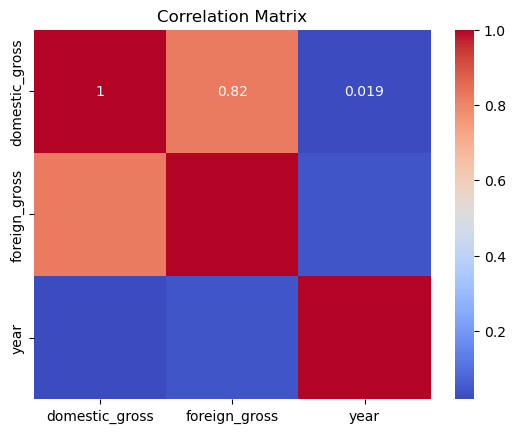

In [96]:
#Correlation analysis
corr = bomdf[['domestic_gross', 'foreign_gross', 'year']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Create a Correlation Matrix Heatmap of Movie Genres.

1. **Strong Positive Correlations**:
   - **Adventure and Action**: These genres have a strong positive correlation, indicating that movies labeled as 'Adventure' are often also labeled as 'Action'.
   - **Comedy and Romance**: These genres also show a strong positive correlation, suggesting that romantic comedies are a common genre combination.

2. **Strong Negative Correlations**:
   - **Documentary and most other genres**: The 'Documentary' genre has low or negative correlations with most other genres, indicating that documentaries are less likely to be classified under multiple genres simultaneously.

3. **Neutral or Weak Correlations**:
   - **Animation and other genres**: The 'Animation' genre shows weak correlations with other genres, suggesting that animated movies are often distinct in their classification.

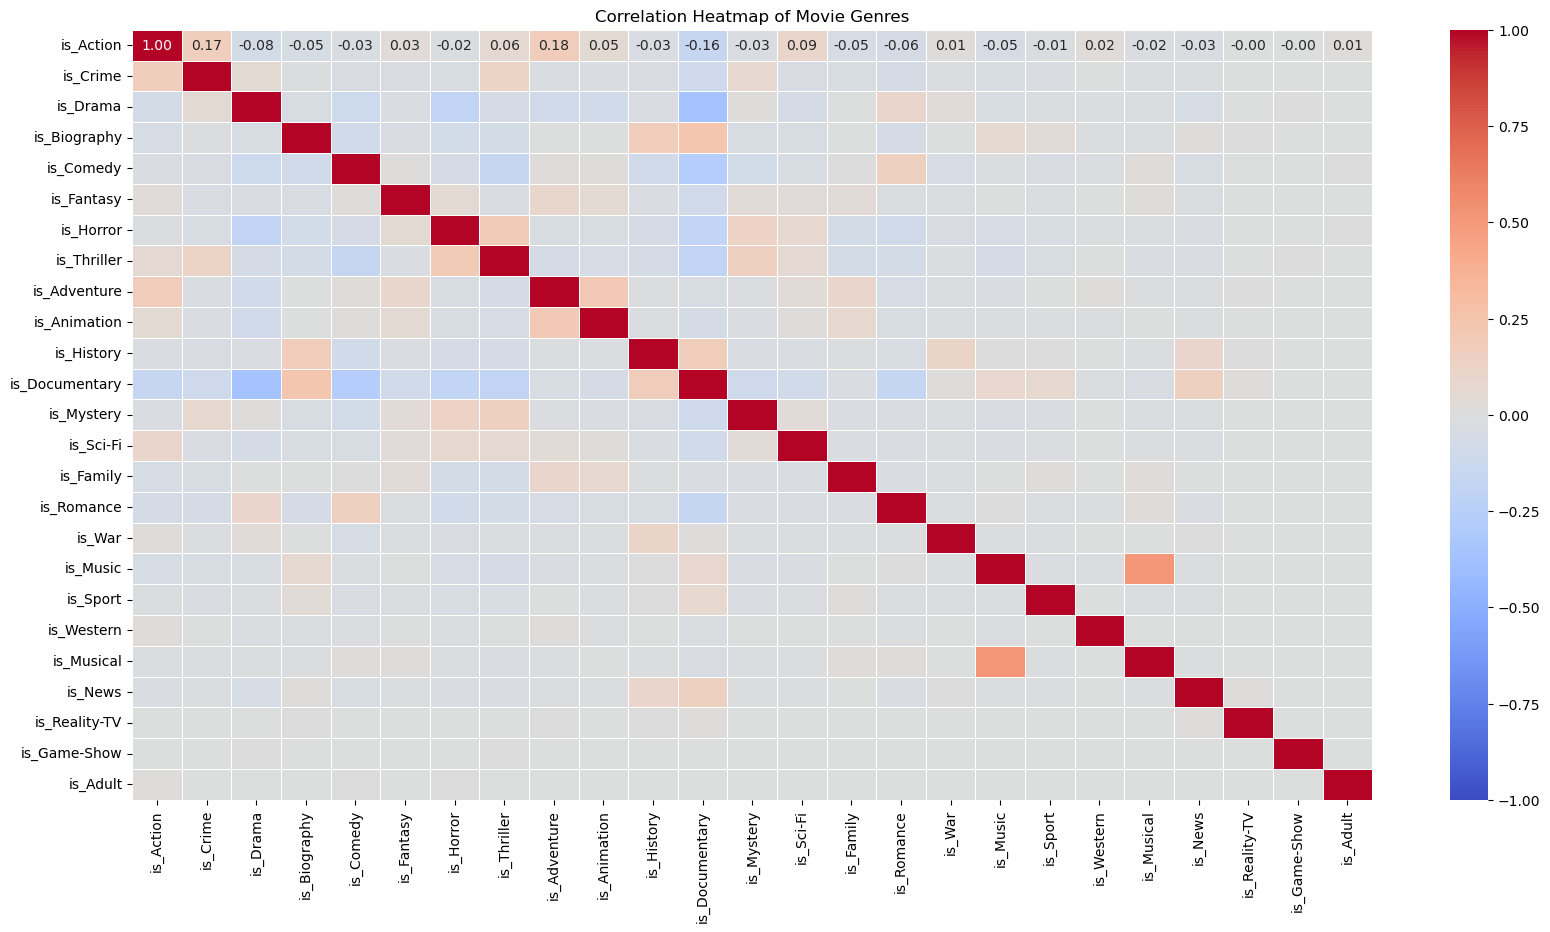

In [97]:
# Selecting the columns of interest
columns_of_interest = ['is_Action', 'is_Crime', 'is_Drama', 'is_Biography', 'is_Comedy',
    'is_Fantasy', 'is_Horror', 'is_Thriller', 'is_Adventure',
    'is_Animation', 'is_History', 'is_Documentary', 'is_Mystery',
    'is_Sci-Fi', 'is_Family', 'is_Romance', 'is_War', 'is_Music',
    'is_Sport', 'is_Western', 'is_Musical', 'is_News', 'is_Reality-TV',
    'is_Game-Show', 'is_Adult']

# Creating a subset of the DataFrame with the specified columns
Heatmap_df = imdf[columns_of_interest]

# Computing the correlation matrix
correlation_matrix = Heatmap_df.corr()

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Movie Genres')
plt.show()

### **Correlation Heatmap of Movie Ratings and Runtimes to Genres**

- **Movie Ratings**: There are positive correlations between movie ratings and certain genres like Drama and Biography, indicating that these genres tend to have higher ratings. 
- However, genres like Horror and Action show weaker or negative correlations with ratings.
- **Runtimes**: Longer runtimes are positively correlated with genres such as Drama and Biography, suggesting that these genres typically have longer movies. 
- In contrast, genres like Animation and Horror tend to have shorter runtimes, as indicated by negative correlations.

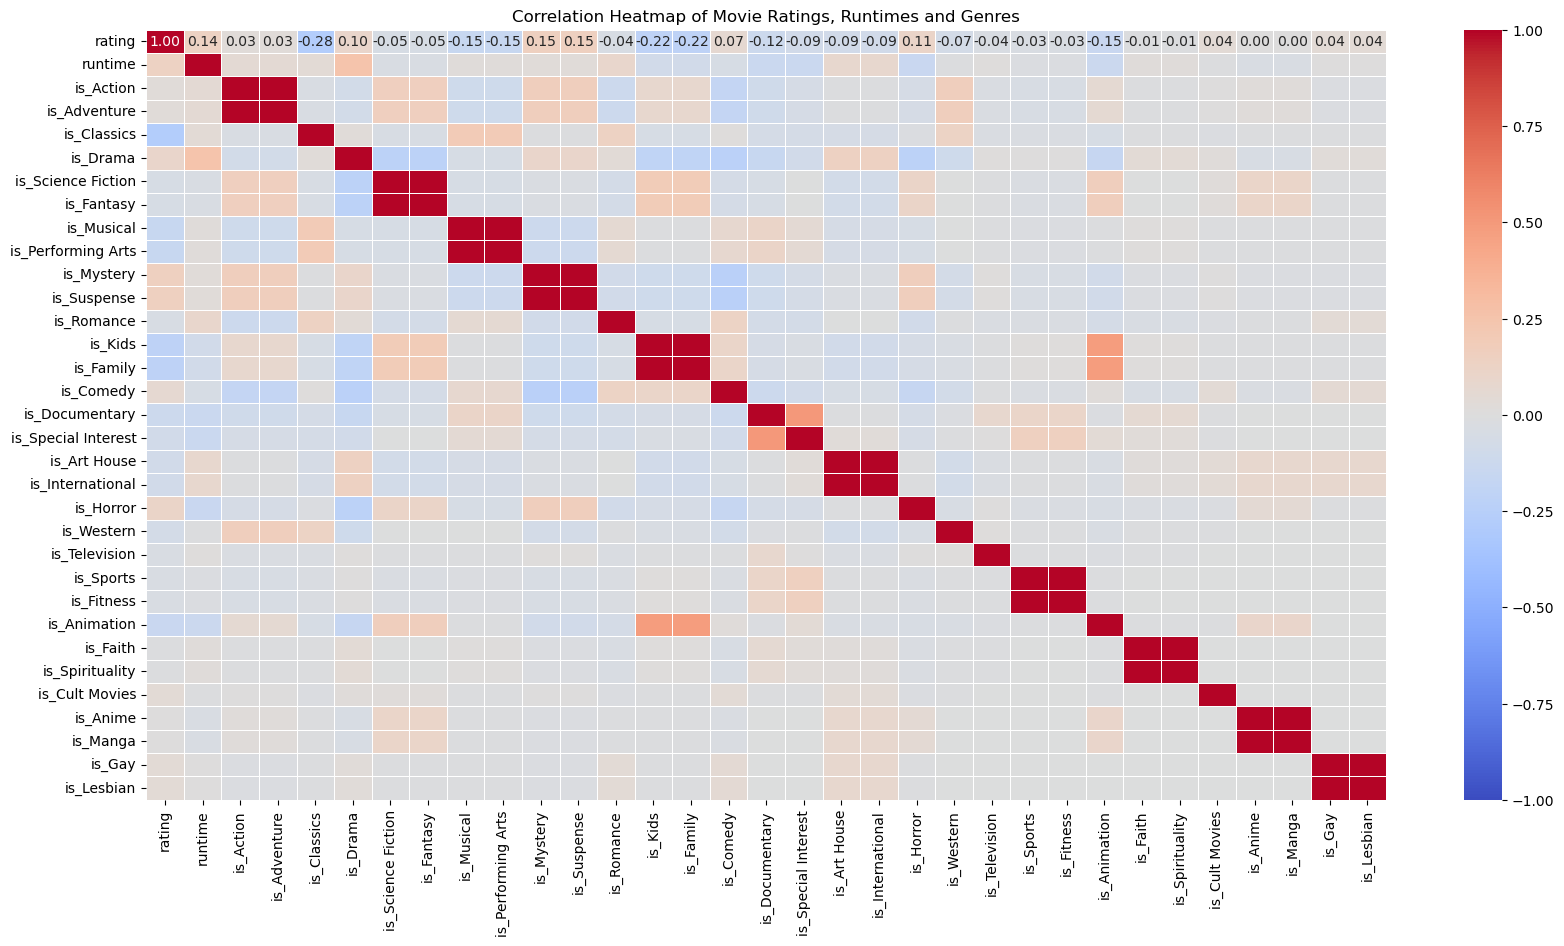

In [98]:
# Creating a copy
rtmdf_copy = rtmdf.copy()

# Convert 'rating' from object to numeric using Label Encoding
le = LabelEncoder()
rtmdf_copy['rating'] = le.fit_transform(rtmdf['rating'])

# Selecting the columns of interest
columns_of_interest = ['rating', 'runtime', 'is_Action',
       'is_Adventure', 'is_Classics', 'is_Drama', 'is_Science Fiction',
       'is_Fantasy', 'is_Musical', 'is_Performing Arts', 'is_Mystery',
       'is_Suspense', 'is_Romance', 'is_Kids', 'is_Family', 'is_Comedy',
       'is_Documentary', 'is_Special Interest', 'is_Art House',
       'is_International', 'is_Horror', 'is_Western', 'is_Television',
       'is_Sports', 'is_Fitness', 'is_Animation', 'is_Faith',
       'is_Spirituality', 'is_Cult Movies', 'is_Anime', 'is_Manga', 'is_Gay',
       'is_Lesbian']

# Creating a subset of the DataFrame with the specified columns
Heatmap_df = rtmdf_copy[columns_of_interest]

# Computing the correlation matrix
correlation_matrix = Heatmap_df.corr()

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Movie Ratings, Runtimes and Genres')
plt.show()

### **Production Budget, Worlwide Gross and Profit**

- **Production Budget vs. Worldwide Gross**: There is a strong positive correlation (0.75), indicating that higher production budgets are associated with higher worldwide gross earnings.
- **Production Budget vs. Profit**: There is a moderate positive correlation (0.61), suggesting that higher production budgets tend to result in higher profits, though not as strongly as with worldwide gross.
- **Worldwide Gross vs. Profit**: The correlation is not explicitly shown, but it is likely strong given the positive correlations with production budget.

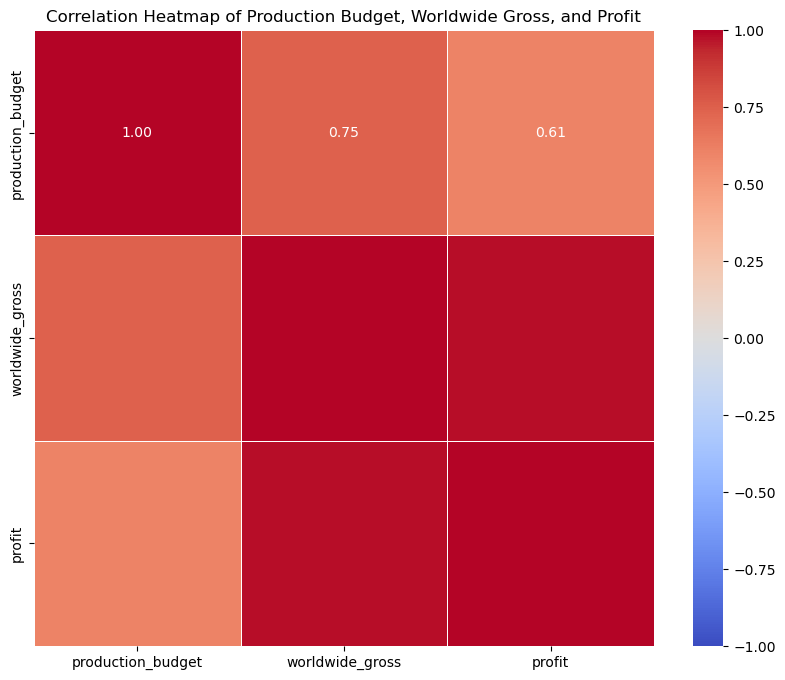

In [99]:
# Selecting the columns of interest
columns_of_interest = ['production_budget', 'worldwide_gross', 'profit']

# Creating a subset of the DataFrame with the specified columns
Heatmap_df = TN_df[columns_of_interest]

# Computing the correlation matrix
correlation_matrix = Heatmap_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Production Budget, Worldwide Gross, and Profit')
plt.show()

## **Statistical Analysis**

In this section, we apply statistical techniques to derive insights from our dataset. We use descriptive statistics like mean, median, variance, and standard deviation to summarize the data's central tendency and dispersion. Inferential statistics, including hypothesis testing, confidence intervals, and regression analysis, help us make predictions or generalizations about a population based on our sample. This analysis will help validate our findings, identify significant patterns, and supports data-driven decision-making.

### Statistical Distribution

**Selecting `runtime_minutes` column**:
   - The column contains information about movie runtimes.
   - This column contains discrete numeric values representing the duration of movies in minutes.

In [100]:
# Selecting a numeric column for analysis, i.e 'runtime_minutes'
data = imdf['runtime_minutes']

**Sampling Statistics**:
   - Creating a sample of 17,292 data points from the `runtime_minutes` column using random sampling (with a fixed random seed for reproducibility).
   - The sample mean (average) is approximately 94.18 minutes. (the central tendency)
   - The sample standard deviation is approximately 20.35 minutes. (variability)

In [101]:
sample_len = int(len(imdf) / 2)
sample = data.sample(sample_len, random_state=42)
mean_sample = sample.mean()
std_sample = sample.std()
print("Sample Mean:", mean_sample)
print("Sample Standard Deviation:", std_sample)

Sample Mean: 94.07618996674859
Sample Standard Deviation: 20.41248989065494


**Probability Mass Function (PMF) of movie runtimes.** 

- **Peak Around 100 Minutes**: The most common runtime appears to be around 100 minutes. This peak suggests that a significant number of movies fall within this duration.

- **Right-Skewed Distribution**: The PMF is right-skewed, meaning there are fewer movies with longer runtimes. Longer movies are less common.

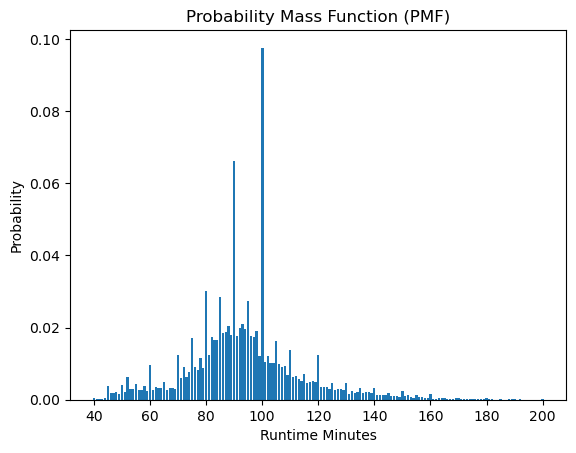

In [102]:
# Calculating Probability Mass Function (PMF)
pmf = sample.value_counts(normalize=True)

# Visualizing PMF
pmf = sample.value_counts(normalize=True)

# Create a bar plot
plt.bar(pmf.index, pmf.values)
plt.xlabel('Runtime Minutes')
plt.ylabel('Probability')
plt.title('Probability Mass Function (PMF)')
plt.show()

**Calculating the **Cumulative Distribution Function (CDF)** of sampled movie runtimes**

   - The curve starts at the bottom left corner (near 0) and progresses in a step-like fashion toward the top right corner (near 1).
   - Each step represents an increase in cumulative probability corresponding to the sampled runtime minutes.
   - The tallest step occurs around 100 to 120 minutes, indicating that a significant proportion of movies fall within this runtime range.
   - In summary, most movies have runtimes around 100 to 120 minutes. 

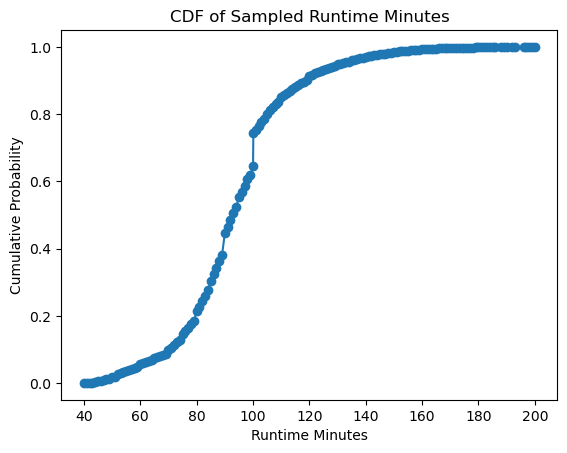

In [103]:
# Cumulative Distribution Function (CDF)
cdf = sample.value_counts(normalize=True).sort_index().cumsum()
plt.plot(cdf.index, cdf.values, marker='o', linestyle='-')
plt.title('CDF of Sampled Runtime Minutes')
plt.xlabel('Runtime Minutes')
plt.ylabel('Cumulative Probability')
plt.show()

**Calculating a Standard Normal Distribution/Z-distribution.**

- **Peak Around Z-Score 0**: The peak of the curve corresponds to the mean Z-score (which is 0). This means that most movie runtimes in are close to the average.

- **Symmetric Shape**: The curve is symmetric around the mean, following the typical bell-shaped pattern of a normal distribution.

- **Tails**: As we move away from the mean (towards positive or negative Z-scores), the density decreases. This indicates that extreme values (far from the mean) are less common.

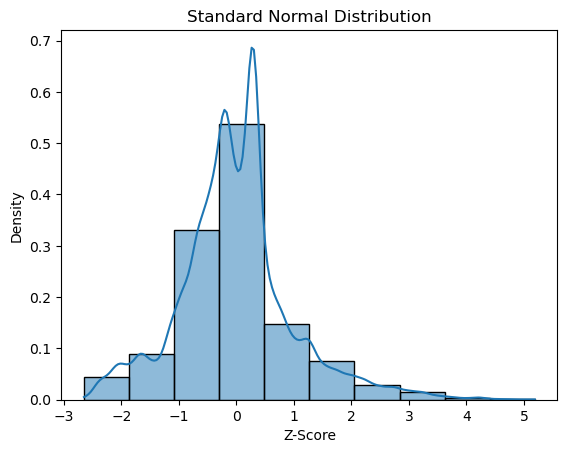

In [104]:
# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Standard Normal Distribution
mean = data.mean()
std = data.std()
sample_len = len(sample)
z = (data - mean) / std

sns.histplot(z, kde=True, stat='density', bins=10)
plt.title('Standard Normal Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Density')
plt.show();
# Re-enable warnings if needed
warnings.filterwarnings('default', category=FutureWarning)

**Calculating Confidence Level**

- **Standard Error**: it represents the variability of the sample mean from the true population mean, it is approximately.

- **T-Distribution Critical Value**: it corresponds to the desired confidence level and the degrees of freedom. For a 95% confidence interval, the critical value is approximately 0.2151.

- **95% Confidence Interval**: it provides a range within which we are confident the true population parameter lies that is (93.86, 94.29) minutes.

In [105]:
# Confidence Level
conf_level = 0.95
n = len(sample)
se = std_sample / np.sqrt(n)
h = se * stats.t.ppf((1 + conf_level) / 2, n - 1)
conf_interval = (mean_sample - h, mean_sample + h)
print("Standard Error:", se)
print("t-distribution critical value:", h)
print("95% Confidence Interval:", conf_interval)

Standard Error: 0.10976202042919954
t-distribution critical value: 0.21513713623847955
95% Confidence Interval: (93.8610528305101, 94.29132710298707)


## Hypothesis Testing

### **ANOVA TEST**

### **ANOVA TEST: `is_Documentary`, `is_Drama` and `is_Comedy`**

- **Between-Group Variability (Sum of Squares)**: `sum_sq` represents the variability for each genre.
     - `C(is_Documentary)` has a variability of approximately 24642.35.
     - `C(is_Drama)` has a variability of approximately 5857.59.
     - `C(is_Comedy)` has a variability of approximately 209.86.

- **Degrees of Freedom (df)**: it represents the number of independent pieces of information available for estimating the population parameters.
     - Each factor (genre) has 1 degree of freedom.
     - The residual (error) has 69167 degrees of freedom.

- **F-Statistic**: it tests whether there are significant differences among the group means.
     - `C(is_Documentary)` has an F-value of approximately 13673.56.
     - `C(is_Drama)` has an F-value of approximately 3250.26.
     - `C(is_Comedy)` has an F-value of approximately 116.45.
   - Larger F-values indicate stronger evidence against the null hypothesis (equal means).

- **p-Value (PR(>F))**: it assesses the significance of the F-statistic.
     - The p-value for `C(is_Documentary)` is effectively 0 (very significant).
     - The p-value for `C(is_Drama)` is also effectively 0.
     - The p-value for `C(is_Comedy)` is extremely small (3.99e-27).
   - All p-values suggest rejecting the null hypothesis.

- **Residual Variability**: The residual sum of squares (124652.10) represents unexplained variability. It accounts for the differences not explained by the genres.
- In summary, the ANOVA results indicate significant differences in average ratings among documentary, drama, and comedy genres.

> Reject Null Hypothesis: There is no significant differences in average ratings among documentary, drama, and comedy genres.

In [106]:
# ANOVA: Analysis of Variance
anova_model = ols('averagerating ~ C(is_Documentary) + C(is_Drama) + C(is_Comedy)', data=imdf).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(is_Documentary),25409.575784,1.0,14089.180909,0.000000e+00
C(is_Drama),6049.785635,1.0,3354.504026,0.000000e+00
C(is_Comedy),120.557513,1.0,66.847106,2.983199e-16
Residual,124741.398352,69167.0,NaN,NaN


### **ANOVA Test: Top 5 Studios to Domestic Gross**

- The **F-statistic** for 'C(studio)' is very high (33588), and the **p-value** is extremely small (\(8.37 \times 10^{-53}\)). This indicates that there are statistically significant differences in domestic gross revenues among different film studios.
- The **Residual** row represents the variation within the groups (studios), and its sum of squares is also quite large, but the F-statistic and p-value are not applicable here.
- The results suggest that the differences in domestic gross revenues between the film studios are not due to random chance. This means that the studio a film belongs to has a significant impact on its domestic gross revenue.

In [107]:
# Identify the top 5 studios
top_5_studios = bomdf['studio'].value_counts().head(5).index.tolist()

# Filter the data to include only the top 5 studios
filtered_data = bomdf[bomdf['studio'].isin(top_5_studios)]

# Perform ANOVA
model = ols('domestic_gross ~ C(studio)', data=filtered_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(studio),1.271331e+18,4.0,74.335887,8.331721e-53
Residual,3.099832e+18,725.0,NaN,NaN


### **A/B Testing**

### **A/B testing of Documentary vs Comedy Movies**

- **Documentary Movies (Red)**: The runtime distribution shows a peak around 90-100 minutes, indicating that most documentaries tend to be around this length.
- **Comedy Movies (Blue)**: The runtime distribution for comedies is more spread out, with a noticeable peak around 100-110 minutes, suggesting that comedies generally have slightly longer runtimes compared to documentaries.

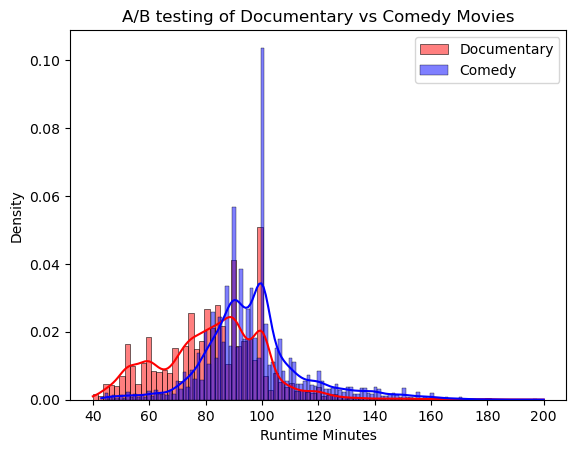

In [108]:
# Suppress warnings if needed
warnings.filterwarnings('ignore', category=FutureWarning)

# A/B Testing
genre1 = imdf[imdf['is_Documentary'] == 1]['runtime_minutes']
genre2 = imdf[imdf['is_Comedy'] == 1]['runtime_minutes']

# Visualizing the distributions
sns.histplot(genre1, kde=True, color='red', label='Documentary', stat='density')
sns.histplot(genre2, kde=True, color='blue', label='Comedy', stat='density')
plt.legend()
plt.title('A/B testing of Documentary vs Comedy Movies')
plt.xlabel('Runtime Minutes')
plt.ylabel('Density')
plt.show();

# Re-enable warnings if needed
warnings.filterwarnings('default', category=FutureWarning)

### **A/B Testing for Universal Pictures and Warner Bros On Domestic and Foreign Gross**
1. **Domestic Gross Revenue**
- **Universal Pictures** (blue) and **Warner Bros** (red) are compared.
- The density plot shows the distribution of domestic gross revenues for both studios.
- Universal Pictures has a wider spread of revenues, indicating more variability.
- Warner Bros has a more concentrated distribution, suggesting less variability in their domestic gross revenues.

2. **Foreign Gross Revenue**
- Similar comparison between **Universal Pictures** (blue) and **Warner Bros** (red).
- Both studios show a wider spread in foreign gross revenues compared to domestic.
- Universal Pictures again shows more variability, while Warner Bros has a more concentrated distribution.

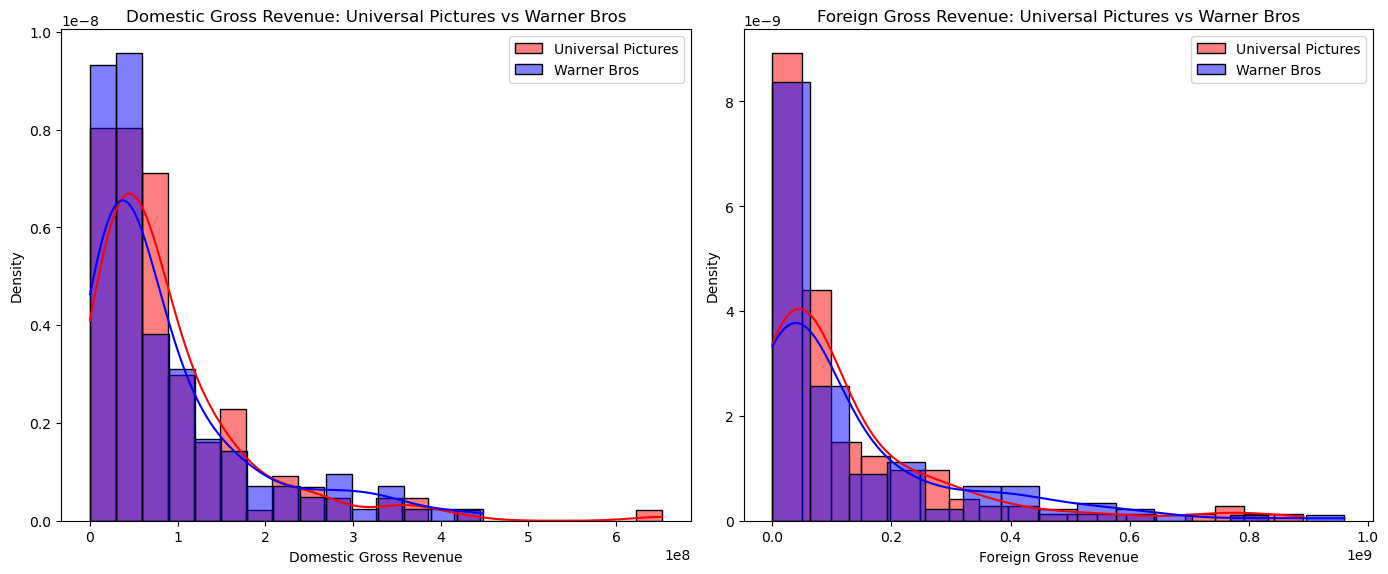

In [109]:
# Suppress warnings if needed
warnings.filterwarnings('ignore', category=FutureWarning)

# A/B Testing
genre1_domestic = bomdf[bomdf['studio'] == 'Universal Pictures']['domestic_gross']
genre2_domestic = bomdf[bomdf['studio'] == 'Warner Bros']['domestic_gross']
genre1_foreign = bomdf[bomdf['studio'] == 'Universal Pictures']['foreign_gross']
genre2_foreign = bomdf[bomdf['studio'] == 'Warner Bros']['foreign_gross']

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Domestic Gross Revenue
sns.histplot(genre1_domestic, kde=True, color='red', label='Universal Pictures', stat='density', ax=axes[0])
sns.histplot(genre2_domestic, kde=True, color='blue', label='Warner Bros', stat='density', ax=axes[0])
axes[0].legend()
axes[0].set_title('Domestic Gross Revenue: Universal Pictures vs Warner Bros')
axes[0].set_xlabel('Domestic Gross Revenue')
axes[0].set_ylabel('Density')

# Foreign Gross Revenue
sns.histplot(genre1_foreign, kde=True, color='red', label='Universal Pictures', stat='density', ax=axes[1])
sns.histplot(genre2_foreign, kde=True, color='blue', label='Warner Bros', stat='density', ax=axes[1])
axes[1].legend()
axes[1].set_title('Foreign Gross Revenue: Universal Pictures vs Warner Bros')
axes[1].set_xlabel('Foreign Gross Revenue')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Re-enable warnings if needed
warnings.filterwarnings('default', category=FutureWarning)

## **Two Sample T-Test**

### **Welch’s T-Test: Drama and Comedy Genres**

- **T-Statistic**: it is a measure of how far the sample means differ from each other relative to the variability within the samples. The t-statistic is approximately 17.52. A larger t-statistic indicates stronger evidence against the null hypothesis (that the means are equal).

- **P-Value**: it represents the probability of observing such extreme results (or more extreme) if the null hypothesis were true. The p-value is approximately 1.79e-66 (which is very close to zero). This extremely small p-value suggests strong evidence against the null hypothesis.

- Since the p-value is very small, you have evidence to conclude that there is a significant difference in the mean runtime between the Drama and Comedy genres. The two genres have different average runtimes.

In [110]:
# T-Test (Two Sample T-Test)
genre1 = imdf[imdf['is_Drama'] == 1]['runtime_minutes']
genre2 = imdf[imdf['is_Comedy'] == 1]['runtime_minutes']

# Performing a Welch’s t-test since they have different variance
t_stat, p_value = stats.ttest_ind(genre1, genre2, equal_var=False)
print(f"T-Test: t-statistic = {t_stat}, p-value = {p_value}")

# Significance Level
a = 0.05
if p_value < a:
    print("Reject Null Hypothesis: There is not a significant difference in the mean runtime between the Drama and Comedy genres")
else:
    print("Accept Null Hypothesis: There is a significant difference in the mean runtime between the Drama and Comedy genres")

T-Test: t-statistic = 4.196449334814912, p-value = 2.717889638958354e-05
Reject Null Hypothesis: There is not a significant difference in the mean runtime between the Drama and Comedy genres


## Test of Movies Released in Summer and Non-Summer
    
> Null Hypothesis (H₀): There is no significant difference in movie profits between movies released Summer and Non-Summer.

> Alternative Hypothesis (H₁): There is a significant difference in movie profits between summer and non-summer months.

In [111]:
# Splitting the dataframe into a subset for summer months 
TN_df['is_summer'] = TN_df['release_month'].isin([5, 6, 7])

# Creating a subset of non summer months from the remaing months and extracting profit values for both subsets.

summer_profits = TN_df[TN_df['is_summer']]['profit']
non_summer_profits = TN_df[~TN_df['is_summer']]['profit']

# Performing a t-test to compare the mean profits between summer and non-summer movies.
t_stat, p_value = stats.ttest_ind(summer_profits, non_summer_profits)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Significance Level
a = 0.05
if p_value < a:
    print("Reject Null Hypothesis: There is no significant difference in movie profits between summer months (May, June, July) and other months.")
else:
    print("Accept Null Hypothesis: There is no significant difference in movie profits between summer and non-summer months.")

T-statistic: 11.956893384010465
P-value: 1.551636561718069e-32
Reject Null Hypothesis: There is no significant difference in movie profits between summer months (May, June, July) and other months.


- Based on the analysis the difference in movie profits between summer and non-summer months is statistically significant.
- From the box plot, we can see that the box for summer movies (True) is slightly higher than for non-summer movies (False).
- From both the t-test and the box plot visualisation we can infer that  Movie profits tend to be high in the months of May, June and July (summer).

## Pearson correlation analysis to determine the linear relationship between production budget and profit.

- The **Pearson Correlation Coefficient** is approximately 0.61, suggesting a moderate positive linear relationship between production budget and profit.
- The **P-value** is 0.0, indicating that this relationship is statistically significant.
- The regression line shows that, generally, as the production budget increases, the profit also tends to increase.
- The analysis suggests that higher production budgets are associated with higher profits for movies. 

Pearson Correlation Coefficient: 0.6090596025065957
P-value: 0.0
Reject Null Hypothesis: There is a significant linear relationship between production budget and profit.


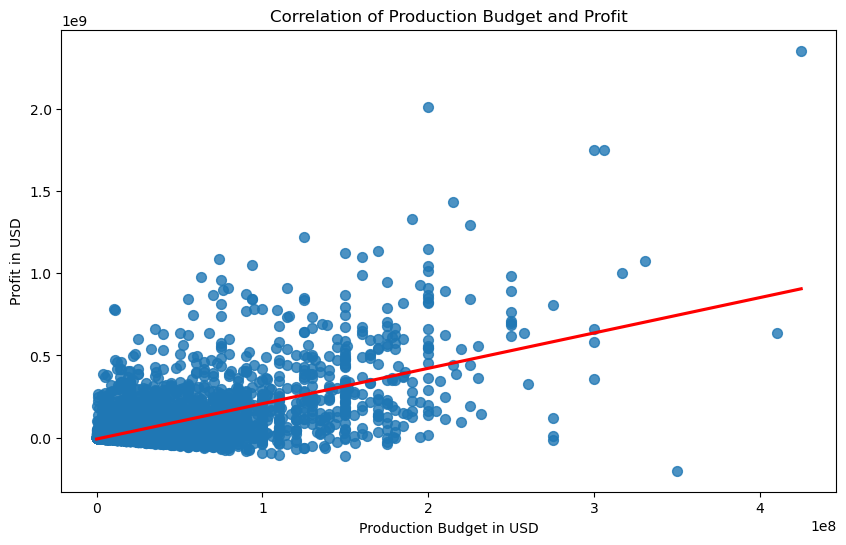

In [112]:
# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(TN_df['production_budget'], TN_df['profit'])
print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

# Significance level
alpha = 0.05
if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant linear relationship between production budget and profit.")
else:
    print("Accept Null Hypothesis: There is no significant linear relationship between production budget and profit.")

# Visualization: Regression plot of production budget vs. profit
plt.figure(figsize=(10, 6))
sns.regplot(data=TN_df, x='production_budget', y='profit', ci=None, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Correlation of Production Budget and Profit')
plt.xlabel('Production Budget in USD')
plt.ylabel('Profit in USD')
plt.show()

## **Linear Regression** 

In [113]:
# Selecting numeric columns for regression, e.g., 'runtime_minutes' and 'averagerating'
X = imdf['runtime_minutes']
y = imdf['averagerating']

### Calculating Cohen's d for `is_Documentary` and `is_Comedy`

- The effect size, specifically Cohen's d, is a measure of the magnitude of the difference between two groups. In your case, you are comparing the average ratings of Comedy and Documentary movies.
- **Cohen's d = -1.042**: This value indicates a large effect size. The negative sign shows that the mean rating for Comedy movies is lower than that for Documentary movies.
- **Magnitude**: 
  - **0.2**: Small effect
  - **0.5**: Medium effect
  - **0.8**: Large effect
- A Cohen's d of -1.042 suggests that there is a substantial difference in average ratings between Comedy and Documentary movies, with Documentaries generally receiving higher ratings than Comedies.

In [114]:
# 1. Effect Size (Cohen's d for two groups)
# Input data
group1 = imdf[imdf['is_Comedy'] == 1]['averagerating']
group2 = imdf[imdf['is_Documentary'] == 1]['averagerating']

# Calculating effect size
effect_size = (group1.mean() - group2.mean()) / np.sqrt((group1.std()**2 + group2.std()**2) / 2)

print("Effect Size (Cohen's d):", effect_size)

Effect Size (Cohen's d): -1.0420659610726977


### Calculating the Statistical Power

- **Statistical Power**: 1.0
  - The value of indicates perfect statistical power.
  - In hypothesis testing, statistical power represents the probability of correctly rejecting a null hypothesis when it is false (i.e., detecting an effect if it truly exists).
  - A power of 1.0 means that our test has a 100% chance of detecting the effect size (Cohen's d = -0.6382).
  - High statistical power is desirable because it minimizes the risk of Type II errors (false negatives).

In [115]:
power_analysis = TTestIndPower()
power = power_analysis.solve_power(effect_size=effect_size, nobs1=len(group1), alpha=0.05)
print("Statistical Power:", power)

Statistical Power: 1.0


### Calculating the Chi-Square Test

- The chi-squared test assesses the independence between two categorical variables.
- It examines whether there is a significant association between the genres "Drama" and "Biography" in your dataset.
    - The chi-squared statistic is 112.93.
    - The p-value is 2.24e-26, indicating strong evidence against the null hypothesis of independence.
    - The null hypothesis assumes that the two variables are independent (i.e., no association).
    - Since the p-value is extremely low, we reject the null hypothesis and conclude that there is a significant association between the genres.

In [116]:
# 3. Chi-Square Test: Testing independence between two categorical variables
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(imdf['is_Drama'], imdf['is_Biography']))
print(f"Chi-Square Test: chi2 = {chi2}, p-value = {p}")

Chi-Square Test: chi2 = 112.92968561841823, p-value = 2.235642079186849e-26


### Performing linear regression model based on `averagerating` and `runtime_minutes`

**Model Information**:
   - **Dependent Variable (y)**: The target variable is the average rating ('averagerating') of movies.
   - **Independent Feature (X)**: The feature used for prediction is the runtime of movies ('runtime_minutes').

In [117]:
# Defining the feature and target
X = imdf['runtime_minutes'] # feature
y = imdf['averagerating'] # target

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

**Regression Coefficients**:
   - The model estimates the relationship between 'averagerating' and 'runtime_minutes'.
   - The coefficient for 'runtime_minutes' is approximately -0.0029.

**Intercept (Constant)**:
   - The intercept (constant) term is approximately 70.48.

**R-squared (R²)**:
   - The R-squared value is 0.002.
   - This indicates that only about 0.2% of the variation in 'averagerating' can be explained by 'runtime_minutes'.

**F-statistic**:
   - The F-statistic is 13.15.
   - It assesses the overall significance of the model.

**p-values**:
   - The p-value for 'runtime_minutes' is 0.001, indicating its significance.
   - The p-value for the intercept is very small (close to 0), suggesting its importance.

**Model Fit**:
   - The model's goodness of fit is modest (R-squared = 0.002).
   - The F-statistic's p-value (0.00296) suggests that the model is statistically significant.

In [118]:
# Statistical Modeling: Linear Regression Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          averagerating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     107.6
Date:                Sun, 28 Jul 2024   Prob (F-statistic):           3.42e-25
Time:                        23:39:06   Log-Likelihood:            -1.2543e+05
No. Observations:               69171   AIC:                         2.509e+05
Df Residuals:                   69169   BIC:                         2.509e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.1338      0.027    2

### Regression Model Evaluation: Residual Plot, QQ Plot, Homoscedasticity, Multicollinearity

#### 1. Residual Plot

**Residual Plot**:
   - A residual plot shows the differences (residuals) between the actual observed values and the predicted values from a regression model.
   - In the plot, each dot represents a data point, and its vertical position indicates the residual (actual value minus predicted value).
   - The horizontal dashed red line at y=0 represents where residuals would be if predictions were perfect (i.e., no error).
   - Ideally, residuals should be randomly scattered around this line with no discernible pattern.

**Interpretation**:
   - If the residuals are randomly distributed around the y=0 line, it suggests that the model's predictions are unbiased and accurate.
   - Patterns (e.g., a funnel shape, U-shape, or curvature) in the residuals may indicate issues with the model (e.g., heteroscedasticity or nonlinearity).
   - The plot appears to follow the expected pattern, with residuals centered around zero.

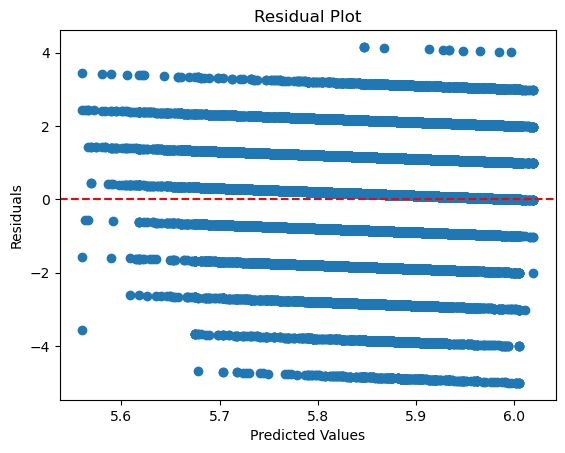

In [119]:
# Residual Plot
plt.scatter(predictions, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

#### 2. QQ Plot

- A QQ plot is used to assess whether a dataset follows a specific theoretical distribution (usually the normal distribution).
- It compares the quantiles of the sample data against the quantiles of the theoretical distribution.

**Interpretation**:
   - The scatterplot in the chart shows points representing quantiles from the sample data plotted against corresponding quantiles of the theoretical distribution (usually the normal distribution).
   - The red reference line at a represents what would be expected if the sample data perfectly followed the theoretical distribution.
   - Points close to this line indicate good agreement between sample and theoretical quantiles.
   - The QQ plot appears to follow the expected pattern.
   - Most points are close to the reference line, suggesting that the residuals (differences between observed and predicted values) align reasonably well with a normal distribution.
   - However, there are some deviations at both ends (tails) of the plot, indicating potential outliers or heavy tails compared to a normal distribution.

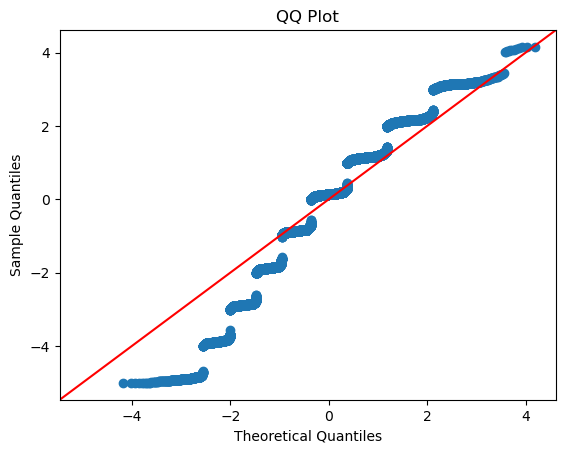

In [120]:
# QQ Plot
sm.qqplot(model.resid, line='45')
plt.title('QQ Plot')
plt.show()

#### 3. Homoscedasticity

- Homoscedasticity refers to the assumption that the variance of the residuals (differences between observed and predicted values) remains constant across all levels of the independent variable (in this case, the predicted values). It means that the spread or dispersion of residuals should be consistent as we move along the range of predicted values.

**Interpretation**:
   - In a homoscedastic scenario, there would be a random scatter of points without any distinct pattern.
   - However, in the plot, there are clear patterns:
     - Bands or lines of points appear at different levels on the y-axis for similar ranges of predicted values.
     - This suggests that the variance of residuals changes with predicted values, which violates the homoscedasticity assumption.
     - Such patterns may indicate **heteroscedasticity** (unequal variance).

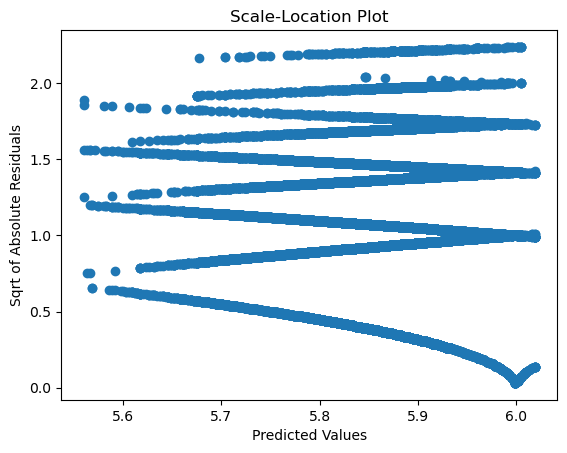

In [121]:
# Homoscedasticity
# Create a Scale-Location Plot
# y-axis represents the square root of the absolute residuals (i.e., the positive values of the residuals).
# x-axis represents the predicted values from the regression model.
plt.scatter(predictions, np.sqrt(np.abs(model.resid)))
plt.xlabel('Predicted Values')
plt.ylabel('Sqrt of Absolute Residuals')
plt.title('Scale-Location Plot')
plt.show()

#### 4. Coefficient of Determination (R²)

In [122]:
r_squared = model.rsquared
print("Coefficient of Determination (R²):", r_squared)

Coefficient of Determination (R²): 0.0015532975418881545


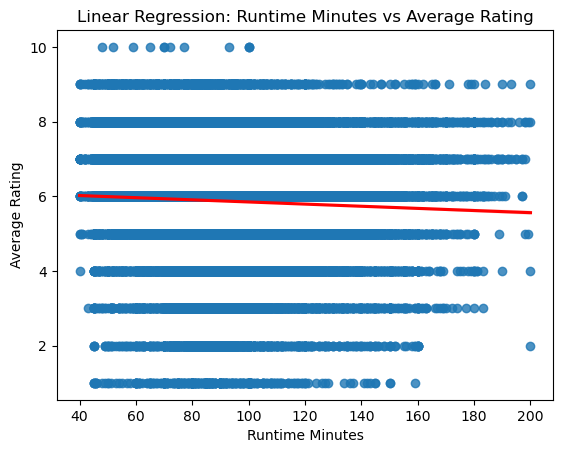

In [123]:
# Visualization: Regression Line
sns.regplot(x='runtime_minutes', y='averagerating', data=imdf, line_kws={"color":"red"})
plt.xlabel('Runtime Minutes')
plt.ylabel('Average Rating')
plt.title('Linear Regression: Runtime Minutes vs Average Rating')
plt.show()

### Prediction to Analyze Studio Performance Based on Domestic and Foreign Gross 

**Mean Squared Error (MSE):** 7.743719292257218e-16
- The MSE is extremely close to zero, indicating that the model's predictions are very accurate. In practical terms, this means the difference between the actual and predicted values is negligible.

**R-squared (R²):** 1.0
- An R² value of 1.0 signifies a perfect fit. This means that 100% of the variance in the target variable (`total_gross`) is explained by the features (`domestic_gross` and `foreign_gross`). The model captures all the variability in the data perfectly.

- The results indicate that the linear regression model is highly effective in predicting the total gross based on domestic and foreign gross. The near-zero MSE and perfect R² value suggest that the model's predictions are almost identical to the actual values, making it a reliable tool for analyzing studio performance.

In [124]:
# Load and clean the data
# Create the target variable and features:
bomdf['total_gross'] = bomdf['domestic_gross'] + bomdf['foreign_gross']
X = bomdf[['domestic_gross', 'foreign_gross']]
y = bomdf['total_gross']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model:
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 7.743719292257218e-16
R-squared: 1.0


### Predict the worldwide gross revenue of movies based on their production budget using a linear regression model

- The scatter plot compares actual and predicted worldwide gross revenues.
- The red regression line indicates the model's predictions.
- The model has a **Mean Squared Error (MSE)** of approximately \(1.6 \times 10^{16}\) and an **R-squared score** of about 0.50.
- An R-squared score of 0.50 suggests that the model explains about 50% of the variability in worldwide gross revenue based on production budget.
- The visualization helps assess how well the model predicts worldwide gross revenue from production budgets. 

Model 1: Predicting worldwide gross based on production budget
Mean squared error: 1.5991486331029718e+16
R-squared score: 0.5041078156339777


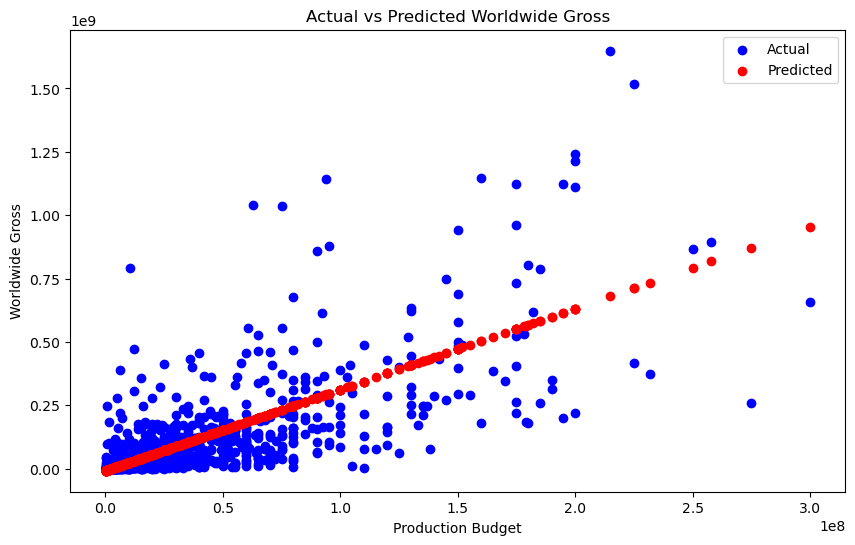

In [125]:
# Select the feature and target variable
X = TN_df[['production_budget']]
y = TN_df['worldwide_gross']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model1 = LinearRegression()
model1.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model1.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model 1: Predicting worldwide gross based on production budget")
print(f"Mean squared error: {mse}")
print(f"R-squared score: {r2}")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Actual vs Predicted Worldwide Gross')
plt.legend()
plt.show()

In [126]:
print(bomdf[['studio', 'domestic_gross', 'foreign_gross', 'year']].head())

                 studio  domestic_gross  foreign_gross  year
0  Buena Vista (Disney)       415000000      652000000  2010
1  Buena Vista (Disney)       334200000      691300000  2010
2           Warner Bros       296000000      664300000  2010
3           Warner Bros       292600000      535700000  2010
4             Paramount       238700000      513900000  2010
